## Exploring Top2Vec on Recipe Topic Generation

Guide here: https://github.com/ddangelov/Top2Vec

#### Notes:
When running Top2Vec with Doc2Vec on the unmodified (only the initial quote and bracket removed from directions; both reformatted into a list of strings) directions and ingredients columns the topics returned were somewhat messy with words like recipe and ingredient sprinkled throughout.

BERT returned far fewer topics on both columns.

Using the "clean" and preprocessed columns, BERT only returned two topics for the ingredients list.

The clean and preprocessed directions column was found to contain nan for some (31 total out of 22k) recipes where the directions were short such as "Mix all the ingredients." and all words were removed during cleaning. There was one instance that numbers were the only characters present for both ingredients and directions. These were removed before running the topic generation model when the column of interest was impacted.

In [1]:
import pandas as pd
from top2vec import Top2Vec

In [41]:
df = pd.read_csv('Recipe_Recommendation/dataset/Recipe_sample_dataset_small_heroclean.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'title', 'ingredients', 'directions',
       'link', 'source', 'NER', 'clean_ingredients', 'clean_directions',
       'clean_ingredients_spice_r', 'clean_directions_spice_r'],
      dtype='object')

In [7]:
model = Top2Vec(documents,ngram_vocab=True,speed='deep-learn')

#embedding_model='all-MiniLM-L6-v2'

2022-06-20 15:49:36,916 - top2vec - INFO - Pre-processing documents for training
2022-06-20 15:49:42,438 - top2vec - INFO - Creating joint document/word embedding
2022-06-20 16:14:12,375 - top2vec - INFO - Creating lower dimension embedding of documents
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2022-06-20 16:14:39,058 - top2vec - INFO - Finding dense areas of documents
2022-06-20 16:14:42,006 - top2vec - INFO - Finding topics


In [8]:
model.get_num_topics()

228

In [9]:
model.get_topics()

(array([['salad dressing', 'tossed salad', 'romaine lettuce', ...,
         'seam side', 'chilled martini', 'baby carrots'],
        ['dissolve jello', 'dissolve jell', 'dissolve gelatin', ...,
         'whipped topping', 'stiff glossy', 'chilled chinese'],
        ['rise', 'let rise', 'doubled', ..., 'pans', 'next step', 'cloth'],
        ...,
        ['plums', 'has turned', 'turned translucent', ..., 'knife blade',
         'hold their', 'lb loaf'],
        ['orzo', 'not mushy', 'your fingertips', ..., 'fat cholesterol',
         'following package', 'springs back'],
        ['prawns', 'pink remains', 'hot coals', ..., 'curry powder',
         'opaque', 'deep fry']], dtype='<U27'),
 array([[0.6148555 , 0.50973964, 0.4550686 , ..., 0.25767222, 0.2575192 ,
         0.25563663],
        [0.56666386, 0.5225972 , 0.52056354, ..., 0.2616884 , 0.26038596,
         0.26016557],
        [0.6059544 , 0.5778352 , 0.5552345 , ..., 0.27921814, 0.27814353,
         0.27693048],
        ...,
      

In [14]:
topic_size, topic_num = model.get_topic_sizes()

In [15]:
sum(topic_size)

22311

#### Topic Scoring Between Unsupervised Models

Here we define "topic concentration," a strategy for scoring different unsupervised topic modeling techniques on this data set.

Briefly, within the data set directions, ingredients, title, and a column labeled NER were provided. NER stands for named entity recognition, this column contains a very clean list of ingredients.

We trained our models on the directions column (untouched besides removing the brackets at the beginning and end). We then used the NER A.K.A. "clean ingredients" to estimate how pure each topic was by calculating "topic concentration." This was done by counting the number of distinct strings in all recipes assigned to a topic and dividing by the number of strings in all recipes without removing duplicates. Maintaining the number of strings in the denominator enables us to arrive at a percent of concentration. The more overlap in ingredients between the recipes will result in a smaller topic concentrations (i.e. a more concentrated topic) and the less overlap would result in a score closer to one (i.e. no concentration/overlap). The denominator is essential as the topics contain different numbers of recipes.

Below we create the mapping of documents to topics dataframe for Top2Vec and import the mapping for BERTopic and CorEx.

In [29]:
import numpy as np
import re

In [57]:
topic_docs = model.document_ids[np.where(model.doc_top==227)]


In [77]:
df['NER'][0][1:-1].split(', ')[0][1:-1]

'Marshmallow Creme'

In [298]:
x = df['NER'].str.replace('"','').str.lower()#.str.split(',')

In [299]:
x = x.str.replace('[','').str.replace(']','')

/var/folders/w6/m13k9fgs76s835wznks2wrwh0000gn/T/ipykernel_66871/4272600193.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x = x.str.replace('[','').str.replace(']','')


In [301]:
df['clean_NER']=x

'marshmallow creme, cream cheese'

In [135]:
df.head()

Unnamed: 0  Unnamed: 0.1                     title  \
0           0          7964                 Apple Dip   
1           1       1765246   Wasabi Whipped Potatoes   
2           2        677031   Caramel Breakfast Rolls   
3           3       1325712  Egg And Sausage Muffins    
4           4        294137                 Taco Soup   

                                         ingredients  \
0  ["1 (7 oz.) jar Marshmallow Creme", "1 (8 oz.)...   
1  ["1 1/2 lb. russet or Yukon gold potatoes, pee...   
2  ["2 (1 lb.) loaves frozen bread dough, thawed"...   
3  ["1/4 cup cream (half & half)", "12 large eggs...   
4  ["2 lb. lean ground beef", "1 small onion, cho...   

                                          directions  \
0  ["Bring cream cheese to room temperature. Mix ...   
1  ["Place potatoes in large saucepan, cover with...   
2  ["Cut 1 loaf of bread into small pieces; place...   
3  ["Preheat oven to 350 \u00b0F (175 \u00b0C). S...   
4  ["Brown ground beef and onions; drain fat.", "...   

                                                link     source  \
0    www.cookbooks.com/Recipe-Details.aspx?id=980881   Gathered   
1  www.vegetariantimes.com/recipe/wasabi-whipped-...  Recipes1M   
2    www.cookbooks.com/Recipe-Details.aspx?id=537560   Gathered   
3  www.epicurious.com/recipes/member/views/egg-an...   Gathered   
4    www.cookbooks.com/Recipe-Details.aspx?id=288957   Gathered   

                                                 NER  \
0              ["Marshmallow Creme", "cream cheese"]   
1  ["russet", "low-fat milk", "butter", "wasabi p...   
2  ["bread", "brown sugar", "regular vanilla pudd...   
3  ["cream", "eggs", "pepper", "salt", "pork saus...   
4  ["lean ground beef", "onion", "pintos", "kidne...   

                                   clean_ingredients  \
0  jar marshmallow creme pkg cream cheese philade...   
1   russet yukon gold potato inch cube  low fat m...   
2   loaf bread dough  brown sugar pkg regular van...   
3   cream half half large egg  pepper  salt  pork...   
4   lean ground beef small onion bean l bean    t...   

                                    clean_directions  \
0  bring cream cheese room temperature mix marshm...   
1  place potato large saucepan cover cold water s...   
2  loaf bread small piece place piece greased x x...   
3  preheat oven f  spray muffin tin spray like pa...   
4  brown ground beef onion fat  boil heat simmer ...   

                           clean_ingredients_spice_r  \
0   jar marshmallow creme   cream cheese philadel...   
1   russet yukon gold potato       fat milk rice ...   
2   loaf frozen bread dough   firmly  brown sugar...   
3                     cream    egg      pork sausage   
4     beef  onion   pinto    kidney bean   l  lim...   

                            clean_directions_spice_r  \
0  bring cream cheese  temperature mix marshmallo...   
1  place potato  saucepan  cold   rinse away star...   
2   loaf bread   place  greased      combine brow...   
3  preheat oven f   muffin tin    pam    bundt mu...   
4  brown  beef onion  fat  remaining  bring boil ...   

                                           clean_NER  
0                  [marshmallow creme, cream cheese]  
1  [russet, low-fat milk, butter, wasabi paste, g...  
2  [bread, brown sugar, regular vanilla pudding, ...  
3          [cream, eggs, pepper, salt, pork sausage]  
4  [lean ground beef, onion, pintos, kidney beans...

In [267]:
def topic_conc(data,col_metric,col_idx,doc_to_topic,col_doc='doc_id',col_topic='topic_id',\
               word_sep=', '):
    """Returns topic concentration score #of unique strings/#of total strings
    
    Parameters
    __________
    
    data
    col_metric: column name of data that your metric is run on; list of strings expected
    col_idx: column name of the index in data that maps to model to doc mapping
    doc_to_topic: mapping of documents to topics data frame with two columns document id and topic id
    col_doc: column name of your document id in doc_to_topic; str, default='doc_id'
    col_topic: column name of your topic id in doc_to_topic; str, default='topic_id'
    
    
    Returns
    _______
    topic_number: int
    topic_score: # of unique words/phrases identified in topic divided by # of all words/phrases identified 
    in topic"""
    
    
    #combine clean string items to 
    df_topic_conc = pd.DataFrame(columns=['topic_num','topic_conc'])
    
    
    for i in list(set(doc_to_topic[col_topic])):
        temp_list = []
#         print(i)
#         print(doc_to_topic[doc_to_topic[col_topic]==i][col_doc])
        for l in doc_to_topic[doc_to_topic[col_topic]==i][col_doc]:
#             print(data[data[col_idx]==l][col_metric][l])
            df_idx = data[data[col_idx]==l].index[0]
            temp_list.extend(data[data[col_idx]==l][col_metric][df_idx])
#         print(temp_list)    
        new_row = {'topic_num':i,'topic_conc':((len(list(set(temp_list))))/(len(temp_list)))}
        
        df_topic_conc=df_topic_conc.append(new_row, ignore_index=True)
        
    return df_topic_conc
        
        
    

In [212]:
df_test_topic_conc = topic_conc(df,'clean_NER','Unnamed: 0',228,doc_topic_map)

0
16          16
39          39
78          78
131        131
138        138
         ...  
22171    22171
22187    22187
22195    22195
22216    22216
22267    22267
Name: doc_id, Length: 489, dtype: int64
['potatoes', 'salt', 'sour cream', 'mayonnaise', 'pepper sauce', 'mustard', 'garlic', 'bacon', 'eggs']
['bunches', 'olive oil', 'lemon', 'salt', 'flowers']
['dressing', 'basil', 'parmesan', 'tomatoes', 'rotini pasta', 'zucchini', 'cherry tomatoes']
['broccoli', 'grated cheese', 'pasta', 'peppercorn', 'baco bits']
['white shoe peg', 'onion', 'parsley flakes', 'olives', 'carrots', 'sour cream', 'mayonnaise', 'mustard', 'vinegar', 'sugar', 'salt']
['baby new potatoes', 'rump steak', 'celery salt', 'baby spinach', 'parsley', 'mustard', 'olive oil', 'lemon rind', 'lemon juice', 'sugar', 'salt', 'grape tomatoes', 'fava beans']
['spiral', 'fully cooked salmon', 'cherry tomatoes', 'cucumber', 'red onion', 'lemon', 'garlic', 'freshly ground pepper', 'vegetable oil', 'dill weed', 'salt', 'hea

['garlic', 'salt', 'boiling potatoes', 'vinaigrette dressing', 'mayonnaise', 'dill pickle', 'radish', 'celery', 'fresh parsley']
['sharp cheese', 'eggs', 'onion', 'salt']
['blue cheese', 'sour cream', 'mayonnaise', 'green onion', 'white vinegar', 'garlic']
['red wine vinegar', 'freshly squeezed lemon juice', 'honey', 'extra-virgin olive oil', 'salt', 'freshly ground black pepper']
['potatoes', 'celery', 'green onion', 'radish', 'parsley', 'mayonnaise', 'vinegar', 'mustard', 'celery', 'salt', 'pepper']
['head lettuce', 'cauliflower', 'onion', 'bacon', 'mayonnaise', 'sugar', 'parmesan cheese']
['white wine vinegar', 'lime juice', 'parsley', 'ground cumin', 'sugar', 'olive oil']
['cabbage', 'golden raisin', 'celery heart', 'pecans', 'apple', 'mayonnaise', 'condensed sweet milk', 'white wine vinegar', 'sugar']
['olive oil', 'red wine vinegar', 'fresh garlic', 'oregano', 'golden', 'pasta', 'olives', 'grape tomatoes', 'feta cheese', 'spring lettuce mix', 'italian parsley', 'red onions']
['ro

['curly', 'cranberries', 'red onion', 'olive oil', 'lemon juice', 'honey', 'chili powder', 'salt', 'pepper']
['green cabbage', 'red cabbage', 'cucumbers', 'carrots', 'roma tomatoes', 'radishes']
['chicken', 'chicken', 'barbecue sauce', 'romaine lettuce hearts', 'red onion', 'fresh cilantro', 'frozen corn', 'black beans', 'cheddar cheese', 'cheese', 'bbq cilantro', 'mayonnaise', 'milk', 'buttermilk', 'fresh cilantro', 'lime juice', 'white vinegar', 'sugar', 'garlic', 'salt', 'cayenne pepper', 'black pepper', 'ground cumin', 'barbecue sauce']
['salad', 'romaine lettuce', 'tomato', 'jicama', 'black beans', 'fresh corn', '\\u00be', 'avocado', 'red bell pepper', '\\u00bc', 'dressing', '\\u00bc', '\\u00bc', 'honey', 'cilantro', 'clove garlic', 'jalapeno pepper']
['sugar', 'vinegar', 'oil', 'salt', 'celery salt', 'cabbage']
['cider vinegar', 'sugar', 'barbecue sauce', 'water', 'mayonnaise', 'mustard powder', 'liquid red pepper', 'cabbage', 'carrots']
['tomatoes', 'yellow cherry tomato', 'feta

['ripley tomatoes', 'blue cheese', 'italian dressing', 'fresh basil', 'fresh ground black pepper', 'fresh ground sea salt']
['young greens', 'celery', 'radishes', 'scallions', 'turkey bacon', 'frozen green peas', 'light mayo', 'cheddar cheese']
['green peas', 'low-fat sharp', 'onions', 'low-fat mayonnaise', 'mustard', 'salad greens']
['zucchini', 'tomatoes', 'green pepper', 'green onion', 'parsley', 'vinegar', 'salt', 'garlic salt', 'black pepper', 'salad oil', 'head lettuce']
['bananas', 'miracle whip salad dressing', 'apple cider vinegar', 'sugar', 'milk', 'walnut pieces']
['cucumber', 'tomatoes', 'green sweet pepper', 'red onion', 'parsley', 'feta cheese', 'black olives', 'dressing', 'tofu', 'red wine vinegar', 'olive oil', 'garlic', 'oregano', 'basil', 'sugar', 'salt']
['balsamic vinegar', 'olive oil', 'cayenne pepper', 'tomatoes', 'olives', 'green olives', 'garlic', 'freshly ground black pepper', 'cream cheese']
['cucumber', 'stalks celery', 'cilantro', 'lime', 'like', 'sticks', '

['lime jello', 'water', 'regular', 'onions', 'vinegar', 'horseradish', 'mayonnaise', 'salt', 'cucumber']
['mandarin oranges', 'water', 'gelatin', 'orange soda', 'frozen whipped topping', 'graham cracker crust']
['chilled champagne', 'orange juice', 'honey', 'orange section', 'mint sprig']
['cherry', 'fruit cocktail', 'bananas', 'marshmallows', 'cottage cheese', 'whipping cream']
['fruit cocktail', 'jello', 'cottage cheese', 'bananas']
['coconut', 'pecans', 'condensed milk', 'strawberry', 'strawberry']
['lemon jello', 'boiling water', 'pineapple', 'cream cheese', 'mayonnaise', 'carrot', 'celery', 'pecans']
['peach', 'peach gelatin', 'whipping cream', 'cream cheese']
['orange juice', 'cranberry sauce', 'raspberry-flavored gelatin', 'whipping cream']
['lemon jello', 'water', 'mayonnaise', 'pimiento cheese', 'green pepper', 'onion', 'carrot', 'celery', 'pineapple']
['orange jello', 'milk', 'pineapple', 'nuts', 'maraschino cherries', 'pineapple', 'cheddar', 'mayonnaise', 'celery']
['fruit c

['lemon jello', 'boiling water', 'pineapple', 'carrots', 'cheddar cheese', 'pecans']
['cranberry sauce', 'boxes raspberry', 'boiling water', 'pineapple', 'walnuts', 'mandarin oranges']
['apple cider', 'cherry gelatin', 'apple', 'unflavored gelatin', 'cold water', 'applesauce', 'cream cheese', 'milk', 'red']
['pineapple', 'water', 'coffee cream', 'creamed cheese', 'lime jello', 'pecans']
['strawberry gelatin', 'boiling water', 'frozen strawberries', 'pineapple', 'bananas', 'sour cream']
['lime gelatin', 'boiling water', 'pineapple', 'cottage cheese', 'cream cheese', 'pimentos', 'hidden valley', 'burpless cucumber']
['cranberries', 'marshmallows', 'sugar', 'apples', 'green grapes', 'pecans']
['sugar', 'flour', 'salt', 'egg', 'marshmallows', 'pecans', 'cornstarch', 'pineapple']
['cranberries', 'sugar', 'marshmallows', 'whipping cream', 'pineapple']
['sweet cherries', 'cherry-flavored gelatin', 'red wine', 'pecans', 'lettuce leaves', 'mayonnaise']
['sugar', 'cranberries', 'cranberry sauce'

['fennel seeds', 'cumin seeds', 'caraway seeds', 'bulgar wheat', 'butter', 'molasses', 'orange rind', 'boiling water', 'water', 'yeast', 'sugar', 'flour', 'rye flour', 'tablespoons wheat gluten', 'baking soda', 'buttermilk']
['active dry yeast', 'warm', 'shortening', 'salt', 'sugar', 'flour']
['yeast', 'water', 'sugar', 'sugar', 'salt', 'oil', 'water']
['active dry yeast', 'warm water', 'egg', 'butter', 'sugar', 'salt', 'flour', 'brown sugar', 'ground cinnamon', 'butter', 'sugar', 'heavy whipping cream', 'vanilla']
['dough', 'warm water', 'honey', 'active dry yeast', 'all-purpose', 'salt', 'olive oil', 'pizza sauce', 'peanut butter', 'black tea', 'rice vinegar', 'soy sauce', 'chili oil', 'fresh ginger', 'honey', 'topping', 'chicken breast half', 'sesame seeds', 'paprika', 'red chile pepper', 'salt', 'green onions', 'mozzarella cheese', 'carrot', 'fresh cilantro']
['active dry yeast', 'water', 'flour', 'fresh mushrooms', 'onion', 'sugar', 'salt', 'butter']
['flour', 'yeast', 'salt', 'ol

['active dry yeast', 'sugar', 'bread flour', 'warm water', 'rosemary', 'salt', 'ground pepper', 'red grapes', 'salt', 'blue cheese', 'honey', 'chives']
['sourdough starter', 'sugar', 'salt', 'warm warm water', 'warm milk', 'butter', 'flour', 'raisins', 'cornmeal']
['golden raisins', 'apricots', 'cherries', 'triple', 'yeast', 'granulated sugar', 'warm water', 'flour', 'butter', 'milk', 'granulated sugar', 'salt', 'egg', 'egg yolk', 'nuts', 'cooking spray', 'butter', 'turbinado']
['milk', 'shortening', 'sugar', 'salt', 'yeast', 'eggs', 'flour']
['sour cream', 'sugar', 'soda', 'salt', 'yeast', 'egg', 'shortening', 'flour', 'butter', 'brown sugar', 'cinnamon']
['milk', 'flour', 'active dry yeast', 'carrots', 'honey', 'salt', 'butter']
['active dry yeast', 'water', 'olive oil', 'white sugar', 'salt', 'flour', 'olive oil', 'mozzarella cheese', 'cheddar cheese', 'pepperoni', 'black olives', 'basil', 'egg']
['active dry yeast', 'warm water', 'cottage cheese', 'sugar', 'onion', 'margarine', 'di

['bread', 'flour', 'water', 'yeast', 'salt', 'sugar', '+', 'tomato sauce']
['flour', 'sugar', 'salt', 'yeast', 'milk', 'oil', 'eggs']
['dough', 'flour', 'yeast', 'salt', 'italian seasoning', 'olive oil', 'warm water', 'sauce', 'tomatoes', 'olive', 'green olives', 'capers', 'parsley', 'basil', 'oregano', 'garlic', 'sugar', 'hot red pepper', 'salt', 'shredded vegan mozzarella cheese']
['yeast', 'salt', 'flour', 'milk', 'water', 'margarine']
['water', 'yeast', 'milk', 'vegetable shortening solid', 'salt', 'flour', 'brown sugar', 'walnuts', 'raisins', 'cinnamon', 'powdered sugar', 'orange juice', 'butter', 'vanilla', 'almond']
['yeast', 'hot water', 'sugar', 'salt', 'eggs', 'sour cream', 'butter', 'flour', 'coconut']
['yeast', 'water', 'bread flour', 'sugar', 'salt', 'butter', 'eggs']
['flour', 'yeast', 'milk', 'sugar', 'salt', 'warm water', 'olive oil', 'butter']
['flour', 'rapidrise', 'sugar', 'salt', 'water', 'shortening', 'potatoes', 'eggs', 'butter', 'lemon filling', 'sugar', 'starch'

['left-over biscuits', 'raisins', 'vanilla', 'sweet milk', 'egg', 'sugar']
['lean beef cubes', 'carrots', 'celery', 'onions', 'tapioca', 'bay leaf', 'tomato sauce', 'water', 'mushrooms']
['corn', 'eggs', 'salt', 'black pepper', 'salad oil', 'sugar', 'milk']
['onion', 'chili powder', 'worcestershire sauce', 'tomato juice', 'red beans']
['frozen king crab', 'butter', 'flour', 'milk', 'light cream', 'chicken broth', 'cheddar cheese', 'mushrooms', 'white wine', 'onion', 'salt', 'paprika']
['doritos', 'cream of chicken soup', 'milk', 'grated cheese', 'onion', 'green chilies']
['broccoli', 'cream of mushroom soup', 'mayonnaise', 'eggs', 'onion', 'cheese', 'salt', 'buttered bread crumbs']
['pork', 'red beans', 'pinto beans', 'brown sugar', 'catsup', 'onion']
['onion', 'margarine', 'cream cheese', 'milk', 'mushrooms', 'beef', 'parmesan cheese', 'parsley']
['well smashed sweet potatoes', 'white sugar', 'eggs', 'milk', 'butter', 'cinnamon', 'vanilla']
['pineapple', 'crackers', 'pineapple juice',

['chicken', 'favorite', 'kernels', 'cheddar cheese', 'corn tortillas']
['corn', 'sour cream', 'mix', 'butter']
['green peppers', 'onion flakes', 'ground beef', 'cream of mushroom soup', 'tomato soup', 'enchilada sauce', 'picante sauce', 'mozzarella cheese', 'cheddar cheese', 'flour tortillas']
['tortilla shells', 'cream cheese', 'grated cheese', 'black olives', 'peppers', 'salsa']
['lime juice', 'salt', 'avocado', 'tomato', 'green leaf', 'flour tortillas']
['vegetable oil', 'onion', 'garlic', 'green peppers', 'oregano', 'ground cumin', 'corn', 'salsa', 'black beans', 'chili powder', 'cream cheese', 'sour cream', 'fresh cilantro', 'flour tortillas', 'mozzarella cheese']
['corn oil', 'eggs', 'green chilies', 'fresh cilantro', 'pepper sauce']
['tortilla', 'onion', 'honey', 'cheese']
['tortilla', 'handful', 'vegetable oil']
['ground beef', 'taco mix', 'beans', 'shredded cheese', 'sour cream', 'green onions', 'nacho cheese soup', 'tortilla chips']
['chicken', 'chicken bullion', 'tortillas',

['chicken', 'black beans', 'tomatoes', 'red bell pepper', 'yellow onion', 'green chiles', 'enchilada sauce', 'favorite salsa', 'flour tortillas', 'shredded monterey jack cheese', 'sour cream']
['cooking spray', 'onion', 'pepper', 'sugar', 'mushrooms', 'garlic', 'madeira wine', 'chicken', 'corn tortillas', 'cheddar cheese', 'light sour cream']
['beans', 'taco', 'avocado dip', 'sour cream', 'chopped ripe olives', 'tomatoes', 'onion', 'green chiles', 'shredded monterey jack cheese', 'tortilla chips']
['summer', 'zucchini', 'onion', 'bell pepper', 'garlic', 'carrots', 'cheese', 'green onions', 'flour tortillas', 'jalapenos', 'salt', 'pepper', 'cooking spray']
['water', 'chiles', 'garlic', 'green onions', 'green chili', 'spinach', 'corn tortillas', 'cheese', 'vegetable oil']
['cream cheese', 'green chilies', 'sour cream', 'picante sauce', 'ham', 'flour tortillas']
['olive oil', 'red onion', 'chili powder', 'black beans', 'frozen corn kernels', 'salsa', 'avocado', 'fresh cilantro', 'flour to

['semi-sweet chocolate', 'pecans', 'flour', 'vanilla', 'margarine', 'sugar', 'eggs']
['egg', 'milk', 'butter', 'bran flakes', 'flour', 'baking powder', 'salt', 'dark brown', 'raisins']
['oats', 'whole wheat flour', 'all-purpose flour', 'baking powder', 'baking soda', 'ground cinnamon', 'ground coriander', 'salt', 'honey', 'buttermilk', 'canola oil', 'eggs']
['flour', 'baking soda', 'bittersweet', 'unsalted butter', 'coffee', 'eggs', 'sugar', 'confectioners sugar', 'fresh raspberries']
['flour', 'sugar', 'baking powder', 'egg', 'milk', 'oil', 'fresh blueberries', 'sugar', 'lemon peel']
['peanut butter', 'chocolate chip cookie roll']
['egg', 'vegetable oil', 'sugar', 'bananas', 'flour', 'baking soda', 'salt', 'oatmeal', 'semisweet mini chocolate chips']
['flour', 'baking soda', 'cinnamon ground', 'salt', 'sugar', 'vegetable oil', 'eggs', 'lemon juice fresh', 'vanilla', 'lemon zest', 'apples green', 'pecans']
['vanilla wafers', 'cream cheese', 'milk', 'eggs', 'lemon juice', 'salt']
['muff

['black beans', 'great northern beans', 'corn', 'green pepper', 'red pepper', 'red onion', 'sugar', 'olive oil', 'apple cider vinegar', 'paprika', 'salt']
['lemon juice', 'onion juice', 'horseradish', 'worcestershire sauce', 'tabasco sauce', 'ketchup', 'chili sauce', 'sour cream', 'shrimp']
['sugar', 'brown sugar', 'heavy cream', 'unsalted butter', 'bourbon', 'salt']
['white cabbage', 'red onion', 'cilantro leaf', 'tomato juice', 'lime', 'honey', 'ground toasted cumin', 'chili', 'hot sauce', 'salt', 'black beans']
['banana chips', 'coconut chips', 'dried apples', 'peaches', 'apricots', 'dates', 'sesame seed', 'sunflower seeds', 'almonds', 'chocolate']
['beans', 'lemon', 'sweet gherkin pickles', 'nutritional yeastl', 'braggs', 'granules', 'granules', 'salt', 'clove garlic', 'cinammon', 'ground cumin', 'dill', 'cracked black pepper', 'cayenne pepper', 'mayonaise', 'canola oil']
['red wine vinegar', 'olive oil', 'onion', 'salt', 'parsley', 'ground dry mustard', 'brown sugar', 'garlic', 'm

['balsamic vinegar', 'olive oil', 'rosemary', 'salt']
['parma', 'butter', 'shallots', 'heavy cream', 'parmigiano-reggiano cheese', 'pecorino romano cheese', 'better', 'salt', 'parsley']
['turkey carcass', 'cold water', 'celery', 'carrots', 'onions', 'flat leaf parsley', 'peppercorn', 'thyme']
['water', 'apple juice', 'kosher salt', 'maple syrup', 'thyme', 'black peppercorns', 'bay leaves', 'garlic', 'pepper', 'apple cider vinegar']
['white cake', 'pints', 'eggs', 'seedless raspberry preserves', 'chambord raspberry liquor', 'bittersweet chocolate squares', 'butter', 'rolled fondant', 'cream cheese', 'unsalted butter', 'vegetable shortening', 'powdered sugar', 'seedless raspberry preserves', 'chambord raspberry liquor', 'fresh raspberry', 'edible flower']
['meatloaf', 'potatoes', 'shredded cheese', 'sour cream']
['olive oil', 'onions', 'garlic', 'green beans', 'salt', 'water', 'balsamic vinegar']
['chicken', 'crystal']
['fontina', 'milk', 'egg yolks', 'butter', 'salt', 'fresh-ground blac

['rub ingredients', 'paprika', 'brown sugar', 'onion soup', 'fresh ground black pepper', 'chili powder', 'salt', 'sugar', 'garlic', 'chile powder', 'cumin', 'ground coriander', 'nutmeg', 'turmeric', 'curry powder', 'marinade ingredients', 'cider', 'rice wine vinegar', 'water', 'wine', 'worcestershire sauce', 'your choice', 'salt']
['ricotta cheese', 'fresh italian parsley', 'eggs', 'kosher salt', 'flour', 'recipe', 'flour', 'butter', 'chicken stock', 'sage']
['beans', 'red bell pepper', 'noodles', 'bay scallops', 'garlic', 'fresh ginger', 'vegetable oil', 'hot chile flakes', 'soy sauce', 'balsamic vinegar', 'sugar', 'green onions']
['potatoes', 'onion', 'pork sausage', 'egg substitute', 'salt', 'pepper', 'garlic', 'margarine', 'canola oil']
['boil eggs', 'korean soy sauce', 'mirin', 'rice vinegar', 'water', 'onions', 'scallions per']
['carrots', 'mushrooms', 'garlic', 'red onion', 'courgette', 'green beans', 'baby corn', 'red bell pepper', 'yellow bell pepper', 'olive oil', 'balsamic v

['dream whip', 'cream cheese', 'pecans', 'pineapple', 'marshmallows']
['angel food cake', 'confectioners sugar', 'cream cheese', 'fruit pie filling']
['condensed milk', 'cherry pie filling', 'bananas', 'pineapple', 'nuts']
['white cake mix', 'eggs', 'frozen coconut', 'sour cream', 'sugar']
['chocolate pudding', 'brown bread', 'eggs', 'milk', 'vanilla', 'sugar', 'butter']
['peaches', 'pears', 'mandarin oranges', 'pineapple', 'maraschino cherries', 'bananas', 'vanilla pudding']
['sugar', 'eggs', 'flour', 'baking powder', 'salt', 'hot milk', 'butter', 'vanilla']
['chocolate pudding', 'dream whip', 'milk', 'vanilla', 'dish pie crusts', 'chocolate', 'instant coffee']
['graham cracker', 'peanut butter', 'equal sugar', 'butter', 'cream', 'peanut butter', 'powdered sugar', 'peanut bars']
['apples', 'bananas']
['jell-o', 'sprinkles']
['vanilla ice cream', 'bananas', 'chocolate chip cookies', 'chocolate syrup', 'cocoa']
['cold milk', 'chocolate instant pudding', 'chocolate sandwich cookies', 'gr

['better', 'italian dressing']
['beef tenderloin', 'salt', 'freshly ground black pepper', 'olive oil', 'rosemary', 'shallot', 'garlic', 'madeira wine', 'low-salt beef broth', 'light butter']
['vegetable oil', 'tenderloin', 'olive oil', 'balsamic vinegar', 'fresh chives', 'orange juice', 'poppy seeds', 'green beans', 'bibb lettuce', 'red leaf', 'mandarin oranges', 'feta cheese', 'walnuts', 'red onion']
['salad', 'boneless beef', 'salt', 'black pepper', 'torn romaine leaves', 'red onion', 'cherries', 'feta cheese', 'lemon vinaigrette', 'olive oil', 'lemon peel', 'lemon juice', 'fresh oregano', 'garlic', 'salt']
['shrimp', 'honey', 'lime zest']
['soy sauce', 'sherry', 'fresh ginger', 'garlic', 'tuna', 'mango', 'red bell pepper']
['flank steak', 'extra-virgin olive oil', 'herbes', 'kosher salt', 'freshly ground black pepper', 'tomatoes', 'scallions', 'garlic', 'extra-virgin olive oil', 'balsamic', 'worcestershire sauce', 'salt', 'crusty bread']
['extra virgin olive oil', 'flank steak', 'ko

['sugar', 'blueberry jam', 'lemon juice', 'hulled strawberries', 'fresh blueberries', 'chilled whipping cream', 'flour', 'baking powder', 'salt', 'ground nutmeg']
['butter', 'brown sugar', 'milk', 'egg', 'flour', 'baking soda', 'chocolate chips', 'pecans']
['\\u00be', 'powdered sugar', 'cocoa', '\\u00bc', 'semi-sweet chocolate chips', 'semi-sweet miniature chocolate chips', 'lighter', 'brown sugar', 'light corn syrup', 'water', 'vanilla', 'egg whites', 'marshmallows', 'puffed wheat cereal']
['egg', 'coffee', 'vanilla', 'butter', 'granulated sugar', 'brown sugar', 'flour', 'oats', 'baking soda', 'ground cinnamon', 'pecans']
['flour', 'baking soda', 'salt', 'butter', 'cocoa powder', 'sugar', 'vanilla', 'buttermilk', 'chocolate chips']
['unsalted butter', 'brown sugar', 'granulated sugar', 'eggs', 'flour', 'salt', 'baking soda', 'chocolate chips', 'semi-sweet chocolate baking squares', 'almond']
['shortening', 'sugar', 'brown sugar', 'eggs', 'vanilla', 'flour', 'baking soda', 'salt', 'mil

['chicken breast', 'tomatoes', 'red pepper', 'green peppers', 'chili pepper', 'garlic', 'garlic', 'celery', 'green onion', 'gingerroot', 'salt', 'cooking oil', 'sugar', 'white pepper', 'cornstarch', 'soy sauce', 'oyster sauce', 'sesame oil']
['chicken breasts', 'green pepper', 'onion', 'celery', 'garlic', 'broccoli', 'white rice', 'glaze', 'peanut oil']
['canola oil', 'garlic', 'soy sauce', 'chicken']
['cornstarch', 'ground ginger', 'fresh vegetables', 'soy sauce', 'oil', 'clove garlic', 'chicken', 'chicken broth']
['eggplants', 'chicken broth', 'peanut', 'fresh ginger root', 'sugar', 'cornstarch', 'bean sauce', 'soy sauce', 'sherry', 'cider vinegar', 'sesame seed oil', 'green onions']
['garam masala', 'red curry', 'ginger paste', 'garlic', 'onions', 'red chilies', 'apple', 'oil', 'flour', 'chicken stock', 'oyster sauce', 'salt', 'brown sugar', 'chicken breasts', 'cornstarch', 'cold water']
['beef', 'oil', 'onion', 'garlic', 'string bean', 'eggs', 'cornstarch', 'water', 'beef stock', '

['caramels', 'heavy cream', '\\u00bc', 'flour', 'oats', 'brown sugar', 'baking soda', 'salt', 'butter', 'weight white chocolate chips']
['eggs', 'milk', 'margarine', 'flour', 'sugar', 'nutmeg']
['cream cheese', 'eggs', 'sugar', 'peanut butter', 'peanuts', 'milk chocolate chips', 'shortening']
['flour', 'butter', 'confectioners sugar', 'filling', 'eggs', 'sugar', 'baking powder', '\\u00bc', 'lemon juice', 'lemon zest', 'confectioners sugar']
['flour', 'sugar', 'soda', 'salt', 'wesson oil', 'vanilla', 'eggs', 'grated apples']
['cherry pie filling', 'white cake mix', 'almonds', 'butter']
['flour', 'salt', 'baking soda', 'butter', 'brown sugar', 'white sugar', 'vanilla', 'eggs', 'milk chocolate']
['flour', 'sugar', 'butter', 'condensed milk', 'eggs', 'vanilla', 'pecans', 'toffee']
['butter', 'brown sugar', 'eggs', 'vanilla', 'flour', 'baking soda', 'quick-cooking', 'condensed milk', 'semi-sweet chocolate chips', 'almonds']
['butter', 'powdered sugar +', 'flour', 'lemon zest', 'salt', 'lemo

['chicken', 'ground black pepper', 'onion', 'cayenne pepper', 'garlic', 'onion', 'garlic', 'thyme', 'oil', 'butter']
['garlic', 'vegetable oil', 'pork tenderloin', 'red onion', 'flour tortillas', 'brown mustard', 'ham', 'dill pickles', 'provolone cheese', 'salt', 'pepper']
['skin-', 'kosher salt', 'oregano', 'freshly ground black pepper', 'rosemary', 'cayenne pepper', 'lemon juice', 'olive oil', 'garlic', 'potatoes', 'chicken broth', 'fresh oregano']
['rib-eye roast', 'salt', 'jus']
['lamb', 'mustard', 'bread crumbs', 'fresh parsley', 'salt', 'pepper', 'butter', 'garlic']
['chicken', 'lemon', 'beer', 'olive oil', 'cavender', 'garlic', 'flour', 'water']
['turkey', 'oranges', 'kosher salt', 'sugar', 'black tea bags', 'bay leaves', 'cloves', 'peppercorns', 'bourbon', 'butter', 'honey', 'dijon mustard', 'brown mustard']
['loin roast', 'garlic', 'olive oil', 'paprika', 'pepper', 'thyme', 'potatoes', 'salt', 'water', 'beef broth', 'onions', 'fresh mushrooms', 'butter', 'vegetable oil', 'all-

['whole kernel corn', 'corn', 'white sugar', 'all-purpose', 'milk', 'eggs']
['flour', 'sugar', 'margarine', 'shortening', 'cocoa', 'water', 'salt', 'vanilla', 'cinnamon', 'eggs', 'buttermilk', 'soda']
['flour', 'sugar', 'egg', 'soda', 'pineapple', 'vanilla']
['sugar', 'eggs', 'pineapple', 'flour', 'vanilla', 'nuts']
['powdered sugar', 'cocoa', 'butter', 'milk', 'vanilla', 'nuts']
['flour', 'sugar', 'cocoa', 'vanilla', 'salt', 'oil', 'eggs', 'baking powder', 'boiling water', 'baking soda']
['cake', 'margarine', 'caster sugar', 'eggs', 'flour', 'cocoa', 'boiling water', 'vanilla', 'chocolate chips', 'filling', 'icing sugar', 'margarine', 'cocoa', 'vanilla', 'boiling water', 'chocolate']
['powdered sugar', 'margarine', 'buttermilk', 'cocoa', 'vanilla']
['unsalted butter', 'semisweet chocolate', 'sugar', 'dark brown sugar', 'vanilla', 'egg whites', 'flour', 'cocoa powder', 'baking soda', 'salt', 'salt', 'cooking spray']
['flour', 'salt', 'sugar', 'cocoa', 'butter', 'eggs', 'vanilla', 'mars

175        175
240        240
468        468
624        624
795        795
         ...  
22181    22181
22204    22204
22236    22236
22294    22294
22305    22305
Name: doc_id, Length: 189, dtype: int64
['butter', 'sugar', 'pecans', 'flour', 'powdered sugar']
['butter', 'powdered sugar', 'salt', 'nut meats', 'vanilla', 'flour']
['margarine', 'powdered sugar', 'wesson oil', 'white sugar', 'eggs', 'vanilla', 'soda', 'salt', 'cream of tartar', 'flour']
['sausage', 'sharp cheese', 'bisquick']
['eggs', 'brown sugar', 'almond flavoring', 'vanilla', 'flour', 'baking powder', 'nuts']
['butter', 'powdered sugar', 'flour', 'vanilla', 'pecans']
['butter', 'powdered sugar', 'water', 'vanilla', 'flour', 'ground pecans']
['butter', 'eggs', 'sugar', 'light brown sugar', 'baking soda', 'vanilla', 'all-purpose', 'chocolate chips', 'butterscotch chips', 'nuts']
['flour', 'baking powder', 'salt', 'butter', 'brown sugar', 'sugar', 'eggs', 'chopped nutmeats', 'vanilla']
['cheese', 'flour', 'butter', 'oli

['chocolate', 'chocolate liqueur', 'chocolate vodka', 'tequila', 'coffee flavor']
['nectar', 'herbal liqueur', 'vodka', 'pear']
['tia maria', 'cream', 'rum', 'cacao']
['lemon', 'sugar', 'armagnac', 'sweet vermouth', 'lemon juice', 'bitters', 'lemon twist']
['white rum', 'liqueur', 'cranberry juice', 'lime juice']
['gin', 'sugar', 'lemon juice', 'lime juice', 'egg', 'mint', 'soda']
['gin', 'brandy', 'orange juice', 'pimento']
['coconut milk', 'fresh strawberries', 'honey']
['bittersweet chocolate', 'vanilla vodka', 'chocolate liqueur', 'irish cream']
['freshly-ground coffee', 'vodka', 'water', 'sugar', 'coffee', 'chocolate', 'coffee liqueur', 'orange bitters', 'milk']
['cognac', 'maraschino liqueur', 'bitters', 'orange juice', 'lemon']
['calvados', 'elderflower', 'white wine']
['sugar', 'water', 'water', 'lemon juice', 'sugar', 'egg', 'tequila', 'lime juice', 'lime wedges', 'coarse kosher salt']
['amaro', 'coffee', 'orgeat', 'branca', 'vodka', 'mezcal', 'rye whiskey', 'bitters', 'cherri

['tomatoes', 'onions', 'green peppers', 'jalapeno peppers', 'vinegar', 'canning salt', 'celery', 'ground red pepper', 'vinegar', 'sugar', 'cumin', 'tomato paste']
['strawberries', 'sugar']
['mustard powder', 'yellow mustard seeds', 'water', 'apple cider vinegar', 'garlic', 'brown sugar', 'salt', 'ground ginger', 'ground turmeric', 'ground cinnamon']
['purslane', 'garlic', 'apple cider vinegar', 'peppercorns']
['zucchini', 'sugar', 'lemon juice', 'pineapple', 'water', 'o']
['jalapenos', 'onion', 'garlic', 'olive oil', 'white vinegar', 'water', 'salt', 'oregano', 'bay leaves']
['ground chuck', 'suet ground with chuck', 'tart apples', 'apple butter', 'vinegar', 'raisins', 'currants', 'water', 'molasses', 'cinnamon', 'cloves', 'allspice', 'nutmeg', 'lemon extract', 'lemon']
['water', 'ginger', 'sugar', 'raisins', 'yeast']
['ketchup', 'brown sugar', 'lemon zest', 'orange zest', 'lemon juice', 'orange juice', 'molasses', 'worcestershire sauce', 'mustard', 'liquid smoke', 'garlic', 'freshly g

['celery', 'onion', 'butter', 'water', 'chicken', 'carrots', 'chicken-flavor', 'basil', 'pepper', 'bay leaf', 'creamette egg noodles', 'parsley']
['condensed chicken broth', 'onion', 'wine vinegar', 'olive oil', 'lemon juice', 'mustard', 'salt', 'pepper', 'potatoes', 'sour cream', 'parsley']
['fideo noodles', 'oil', 'clove garlic', 'onion', 'tomato sauce', 'boiling water', 'bouillon cubes']
['chicken', 'onion', 'coconut oil', 'lemon juice', 'garlic', 'bouillon', 'ginger paste', 'flour', 'parmesan cheese', 'butter', 'whipping cream', 'cayenne pepper', 'egg noodles']
['ground beef', 'cheddar cheese', 'dish pie shell', 'tomato sauce', 'bell peppers', 'eggs', 'flour']
['potatoes', 'carrots', 'olive oil', 'onion', 'celery', 'broccoli', 'zucchini', 'water', 'frozen lima beans', 'frozen sweet peas', 'celery', 'sage', 'marjoram', 'salt']
['carrots', 'tomato soup', 'onion', 'pepper', 'sugar', 'vinegar']
['shrimp', 'onion', 'green pepper', 'celery', 'clove garlic', 'ginger root', 'tomatoes', 'pa

['trout', 'miracle', 'mustard', 'ground coriander', 'garam masala', 'green onions', 'fresh coriander', 'lemon juice', 'chaat masala']
['fish', 'lemons', 'olive oil', 'capers', 'whole red peppercorns', 'salt', 'parsley', 'bread']
['salt', 'pepper', 'lemons', 'tomatoes', 'olive oil', 'onion', 'garlic', 'parsley flakes']
['white fillets', 'fennel bulb', 'baby leeks', 'butter', 'vegetable oil', 'cauliflower']
['salmon', 'pepper', 'salt', 'olive oil', 'sour cream', 'horseradish', 'milk', 'dill']
['salmon', 'olive oil', 'ginger', 'ground cumin', 'ground turmeric', 'ground coriander', 'paprika', 'kosher salt', 'whole almond', 'pineapple salsa']
['trout', 'cayenne', 'all-purpose', 'butter', 'pecans', 'lemon juice', 'parsley']
['black cod', 'lemons', 'capers', 'garlic', 'thyme', 'olive oil']
['white fish', 'fish', 'potatoes', 'scallions', 'flour', 'tartar sauce', 'egg', 'breadcrumbs', 'sunflower oil']
['paper', 'red snapper', 'basil pesto', 'grape tomatoes', 'yellow bell pepper']
['turkey breas

['chicken breasts', 'frozen spinach', 'mushroom', 'pesto sauce', 'noodles', 'chicken broth', 'salt']
['pasta', 'cream', 'butter', 'romano cheese', 'parmesan cheese', 'garlic', 'salt', 'olive oil', 'onion', 'mushrooms', 'frozen shrimp']
['salt', 'pasta', 'combination', 'freshly ground black pepper', 'milk']
['linguine', 'dressing', 'smooth peanut butter', 'peanut oil', 'soy sauce', 'rice wine vinegar', 'fish sauce', 'asian chili sauce', 'sesame oil', 'sugar', 'ground pepper', 'garlic powder', 'cucumber', 'red bell pepper', 'green onion', 'vegetables', 'sesame seeds', 'cilantro']
['fresh linguine', 'fresh broccoli', 'tomatoes', 'red wine vinegar', 'olive oil', 'scallions', 'fresh basil', 'salt', 'pepper', 'parmesan cheese']
['tomatoes', 'butter', 'chicken', 'sugar', 'salt', 'freshly ground pepper', 'whole wheat breadcrumbs', 'parmesan cheese', 'lemon zest', 'freshly chopped parsley', 'garlic', 'salt', 'olive oil', 'butter', 'chicken breasts', 'noodles', 'lemon juice']
['broccoli', 'fettu

['graham cracker crumbs', 'sugar', 'coconut', 'butter', 'chocolate chips', 'cream cheese', 'condensed milk', 'eggs', 'vanilla']
['chicken', 'celery', 'almonds', 'salt', 'accent', 'lemon juice', 'bread']
['chocolate pudding', 'cold milk', 'chocolate chips', 'marshmallows', 'crackers']
['pineapple', 'powdered sugar', 'cream cheese', 'pecans']
['marshmallows', 'chocolate almond', 'milk', 'graham crackers', 'powdered sugar', 'butter', 'whipping cream']
['graham crackers', 'butter', 'sugar', 'carnation milk', 'egg', 'pecans', 'coconut', 'graham cracker crumbs']
['butter', 'peanut butter', 'powdered sugar', 'graham cracker crumbs', 'chocolate chips']
['pineapple', 'sour cream', 'instant vanilla pudding', 'graham cracker crusts']
['condensed milk', 'lemon juice', 'oranges', 'pineapple']
['chocolate wafers', 'sugar', 'butter', 'cream cheese', 'marshmallow creme', 'orange sherbet', 'chocolate wafers']
['graham cracker crumbs', 'butter', 'confectioners sugar', 'chunky peanut butter', 'semi-sweet

['parmesan cheese', 'butter', 'flour', 'milk', 'eggs', 'cayenne pepper', 'gruy\\u00e8re cheese', 'ham', 'fresh chives']
['egg whites', 'sugar', 'graham cracker crumbs', 'baking powder', 'vanilla', 'pecans', 'salt', 'cream']
['cream cheese', 'cake flour', 'cornstarch', 'sugar', 'milk', 'butter', 'egg yolks', 'egg whites', 'lemon juice', 'salt', 'margarine', 'cream of tartar']
['shortening', 'sugar', 'salt', 'egg yolks', 'vanilla', 'milk', 'cake flour', 'baking powder', 'egg whites', 'sugar', 'sugar', 'cinnamon', 'blanched almonds']
['egg yolks', 'sugar', 'heavy cream', 'grand marnier']
['heavy whipping cream', 'powdered sugar', 'liqueur triple', 'chocolate', 'butter', 'bananas', 'egg whites', 'cream of tartar', 'sugar', 'vanilla']
['egg whites', 'vanilla', 'cream of tartar', 'salt', 'sugar', 'chocolate', 'salt', 'heavy cream']
['crackers', 'pecans', 'sugar', 'whipped cream', 'sugar', 'egg whites', 'vanilla']
['brown sugar', 'butter', 'light corn syrup', 'pecans', 'bread', 'orange zest',

['italian bread', 'butter', 'eggs', 'anchovy', 'capers', 'garlic', 'basil', 'freshly ground black pepper', 'thin']
['unsalted butter', 'extra-virgin olive oil', 'russet potatoes', 'shallots', 'course salt', 'red-pepper']
['muffins', 'water', 'sweet pickle', 'white onion', 'stalks celery', 'bay seasoning', 'mayonnaise', 'radishes', 'salt', 'black pepper', 'tomatoes', 'cheddar cheese']
['tuna', 'slihgst cheese', 'onyon', 'sweet relish', 'wip']
['ham', 'swiss cheese', 'rolls', 'mustard', 'onion', 'worcestershire sauce', 'sesame seed']
['nut', 'butter']
['cheese', 'onion', 'salad dressing', 'mustard']
['milanesa', 'ground cumin', 'salt', 'limes', 'avocado', 'beans', 'cr\\u00e8me fra\\u00eeche', 'iceburg lettuce', 'tomato', 'jack cheese', 'bolillos', 'oil']
['sandwich rolls', 'fully ripe avocado target', 'fresh cilantro', 'kraft classic ranch dressing', 'clove garlic', 'honey', 'quesadilla cheese', 'green chiles', 'taco', 'oil']
['white bread', 'butter', 'salt', 'pepper', 'garlic', 'cinnamo

['brown sugar', 'milk', 'butter', 'salt', 'vanilla', 'nuts']
['sugar', 'water', 'vinegar', 'salt', 'gelatine', 'cold water', 'egg whites']
['honey', 'egg', 'lemon juice', 'cinnamon']
['sugar', 'white vinegar', 'water']
['butter', 'sugar', 'nuts', 'milk']
['oleo', 'milk', 'sugar', 'white candy making wafers', 'marshmallow creme', 'walnuts', 'vanilla']
['unsalted butter', 'sugar', 'salt', 'light corn syrup', 'hazelnuts', 'bittersweet chocolate']
['sugar', 'milk', 'oleo', 'butterscotch chips', 'marshmallow cream', 'nuts', 'vanilla']
['corn', 'brown sugar', 'white syrup', 'oleo', 'vanilla', 'soda']
['sugar', 'salt', 'water', 'walnuts', 'semi-sweet chocolate', 'butter']
['sugar', 'white syrup', 'water', 'coconut', 'vanilla', 'baking soda']
['peanuts', 'salt', 'margarine', 'baking soda', 'sugar', 'corn syrup']
['butter', 'sugar', 'almonds']
['sugar', 'water', 'peanuts', 'red food coloring', 'margarine', 'salt', 'vanilla']
['sugar', 'cinnamon', 'milk', 'nuts', 'vanilla']
['corn', 'sugar', 'co

['cream cheese', 'milk', 'crab meat', 'onion', 'horseradish', 'salt', 'almonds']
['hominy', 'tomato sauce', 'tuna', 'green pepper', 'onion', 'ground cumin', 'cheddar cheese']
['ground sirloin', 'garlic salt', 'pepper', 'salt', 'tomato sauce', 'noodles', 'sour cream', 'onions', 'cheddar cheese', 'garlic']
['macaroni', 'ground beef', 'onion', 'garlic powder', 'cheddar cheese', 'whole kernel corn', 'tomato soup']
['ground beef', 'onion', 'green pepper', 'garlic powder', 'oregano', 'bay leaves', 'olive oil', 'tomato sauce', 'green olives', 'potatoes', 'rice']
['rice', 'butter', 'beef consomme', 'mushrooms']
['ground beef', 'spaghetti sauce', 'cottage cheese', 'parmesan', 'mozzarella cheese', 'rigatoni noodles']
['noodles', 'mushroom soup', 'pet milk', 'corned beef', 'grated cheese', 'onion', 'potato chips']
['rice', 'onion', 'bell pepper', 'salt', 'tomatoes', 'sausage']
['butter', 'onion', 'sour cream', 'cream of mushroom soup', 'potatoes', 'cheddar cheese']
['yellow squash', 'oil', 'mayon

['unsalted butter', 'olive oil', 'zucchini', 'garlic', 'white wine', 'salmon fillet', 'fresh basil', 'salt', 'freshly ground black pepper', 'walnuts']
['extra-virgin olive oil', 'zucchini', 'basil', 'cheese', 'pine nuts', 'garlic', 'vidalia', 'water', 'kosher salt', 'penne pasta', 'heavy whipping cream', 'freshly ground black pepper']
['ground round', 'pasta sauce', 'salt', 'pepper', 'hot cooked fusilli', 'mozzarella']
['olive oil', 'garlic', 'red pepper', 'clam juice', 'salt', 'capellini pasta', 'shrimp', 'lemon zest', 'lemon juice', 'parsley']
['chicken broth', 'sweet red peppers', 'sugar', 'paprika', 'shrimp', 'heavy whipping cream', 'romano cheese', 'salt', 'pepper', 'hot pepper']
['fettuccine', 'olive oil', 'onion', 'tomatoes', 'baby kale', 'shrimp', 'whipping cream', 'cheddar cheese', 'parmesan cheese']
['beans', 'green beans', 'kidney beans', 'grape tomatoes', 'onion', 'lemon juice', 'sugar', 'olive oil', 'salt', 'basil', 'oregano', 'garlic', 'pepper']
['green beans', 'italian s

['frozen california mix', 'celery', 'onion', 'mayonnaise', 'oleo', 'cheddar cheese', 'cracker crumbs']
['pork', 'brown sugar', 'powdered mustard', 'barbecue sauce', 'salt']
['rice', 'coconut', 'raisins', 'sugar', 'salt', 'eggs', 'milk', 'vanilla']
['milk', 'flour', 'salt', 'dill', 'tuna', 'broccoli', 'pasta', 'cheddar cheese', 'mozzarella cheese', 'cracker crumbs']
['vegetables', 'olive oil', 'pasta', 'parmesan cheese']
['onion', 'margarine', 'green beans', 'sour cream', 'grated cheese']
['broccoli', 'chicken breasts', 'cream of chicken soup', 'mayonnaise', 'lemon juice', 'curry powder', 'breadcrumbs', 'cheddar cheese', 'butter']
['butter', 'onion', 'cream of chicken soup', 'milk', 'rice', 'water', 'broccoli']
['cream cheese', 'bean chili', 'jalapeno peppers', 'cheese']
['broccoli', 'cream of mushroom soup', 'cheddar cheese', 'mayonnaise', 'onion', 'eggs', 'buttered ritz crackers']
['broccoli', 'cream of mushroom soup', 'milk', 'onions', 'seasoning']
['chicken breasts', 'frozen broccol

['all-purpose', 'pepper', 'chicken breast halves', 'vegetable oil', 'onion', 'butter', 'chicken broth', 'lemon juice', 'basil', 'thyme', 'lemon slices', 'parsley', 'rice']
['broccoli spears', 'cheddar cheese', 'ham', 'rice', 'margarine', 'flour', 'pepper', 'milk', 'lemon juice', 'sour cream']
['flour', 'onions', 'salt', 'ground mustard', 'pepper', 'milk', 'frozen', 'elbow macaroni', 'ham', 'cheddar cheese']
['chicken breasts', 'butter', 'salt', 'sherry wine', 'lemon rind', 'lemon juice', 'heavy cream', 'parmesan cheese']
['crawfish', 'onion', 'celery', 'bell pepper', 'oleo', 'milk', 'jalapeno cheese', 'american cheese', 'egg noodles']
['mushrooms', 'butter', 'cornstarch', 'shredded cheese', 'salt', 'cayenne pepper', 'bread']
['corn', 'heavy cream', 'sugar', 'milk', 'flour', 'parmesan cheese', 'butter', 'salt', 'pepper']
['corn', 'water', 'butter', 'mustard', 'salt', 'pepper', 'hot sauce', 'cheddar cheese']
['center', 'brown sugar', 'cornstarch', 'water', 'acceptable margarine', 'raisin

['white onion', 'serrano chiles', 'green bell peppers', 'cider vinegar', 'kosher salt']
['chicken broth', 'chicken breasts', 'red potatoes', 'baby carrots', 'zucchini', 'tomatoes', 'celery', 'onion', 'red bell pepper', 'garlic', 'low-fat peanut butter', 'parsley']
['cabbage', 'onion', 'healthy choice tomato juice', 'kidney beans', 'chili seasoning mix']
['chicken breasts', 'red pepper', 'mushrooms', 'grape tomatoes', 'olive oil', 'salt', 'pepper', 'garlic', 'mozzarella cheese']
['boiling water', 'milk', 'cream cheese', 'butter', 'sour cream', 'garlic salt', 'pepper', 'fresh parsley']
['chuck roast', 'ketchup', 'brown sugar', 'red wine vinegar', 'mustard', 'worcestershire sauce', 'liquid smoke flavoring', 'salt', 'black pepper', 'garlic']
['short', 'short', 'edamame', 'ochazuke wakame', 'nametake chazuke']
['round roast', 'flour', 'russet potatoes', 'onions', 'frozen peas', 'cream of mushroom soup', 'red wine', 'mushrooms', 'ground black pepper']
['sausage', 'kidney beans', 'great north

['egg yolks', 'butter', 'olive oil', 'water', 'pecans', 'brown sugar', 'salt', 'pastry flour', 'eggs', 'olive oil', 'maple syrup', 'brown sugar', 'dark rum', 'pecans', 'cherries']
['flour', 'baking powder', 'sugar', 'salt', 'butter', 'cinnamon']
['water', 'butter', 'salt', 'flour', 'eggs', 'butter', 'onions', 'mushroom', 'sour cream']
['flour', 'salt', 'cayenne pepper', 'butter', 'cheddar cheese', 'sesame seeds', 'soy sauce', 'water']
['ingredients', 'flour', 'salt', 'cold butter', 'water', 'filling ingredients', 'sugar', 'flour', 'ground nutmeg', 'allspice', 'ground cinnamon', 'fresh blueberries']
['flour', 'salt', 'egg yolks', 'cold water', 'filling', 'filling', 'filling', 'filling', 'filling', 'sour cream']
['eggs', 'sugar', 'lime juice', 'unsalted butter', 'lime zest', 'sugar', 'water', 'lime juice', 'mixed berries', 'flour', 'cold unsalted butter', 'vegetable shortening', 'salt', 'water']
['lard', 'butter', 'flour', 'baking powder', 'salt', 'eggs', 'vinegar']
['peaches', 'flour', 

['sugar', 'butter', 'eggs', 'sour cream', 'flour', 'soda', 'vanilla']
['sugar', 'eggs', 'wesson oil', 'flour', 'cinnamon', 'cloves', 'nuts']
['egg', 'sugar', 'butter', 'flour', 'baking soda', 'ground ginger', 'cinnamon', 'molasses', 'honey', 'hot water', 'sauce']
['sugar', 'butter', 'eggs', 'baking powder', 'flour', 'buttermilk', 'baking soda', 'vanilla']
['clear vanilla', 'milk', 'vegetable shortening', 'confectioners sugar']
['butter', 'sugar', 'eggs', 'flour']
['butter', 'flour', 'sugar', 'eggs', 'vanilla']
['sugar', 'flour', 'soda', 'salt', 'cinnamon', 'oil', 'eggs', 'carrots']
['butter', 'crisco', 'sugar', 'flour', 'eggs', 'almond flavoring', 'vanilla flavoring', 'dew']
['pumpkin', 'sugar', 'milk', 'eggs', 'cloves', 'nutmeg', 'cinnamon']
['margarine', 'sugar', 'cream cheese', 'heavy cream', 'strawberry jell-o', 'boiling water', 'strawberries']
['margarine', 'sweetener', 'eggs', 'applesauce', 'pecans', 'dates', 'cinnamon', 'cloves', 'vanilla', 'soda', 'flour']
['margarine', 'crisco

['head cabbage', 'green onions', 'sunflower seeds', 'almonds', 'ramen noodles', 'noodles', 'oil', 'vinegar', 'accent', 'salt']
["campbell's condensed onion soup", 'ketchup', 'salad oil', 'vinegar', 'brown sugar', 'worcestershire sauce', 'hot pepper sauce', 'garlic', 'fryers']
['boiling-hot water', 'coarse bulgur', 'lemon juice', 'extra-virgin olive oil', 'ground cumin', 'tomatoes', 'cucumber', 'jicama', 'cilantro', 'mint leaves', 'pine nuts']
['red new potatoes', 'red pepper', 'green onions', 'oscar mayer', 'italian dressing', 'mayonnaise']
['milk', 'ketchup', 'philadelphia cream cheese', 'french dressing', 'onions']
['dessert wine', 'fresh basil', 'honey', 'peaches']
['brandy', 'dark creme', 'creme', 'heavy whipping cream', 'water']
['bacon', 'pecans', 'mayonnaise', 'velveeta cheese', 'chives']
['onion', 'broccoli', 'cauliflower', 'bacon bits', 'mayonnaise', 'sugar', 'parmesan cheese', 'vinegar', 'salt']
['pineapple juice', 'olive oil', 'lime juice', 'fresh cilantro', 'ground cumin', 

['butter', 'margarine', 'fresh mushrooms', 'mushroom soup', 'cheese', 'yogurt', 'green onions', 'freshly ground black pepper', 'celery seeds', 'red pepper', 'macaroni', 'wheels', 'water', 'fresh vegetables', 'frozen vegetables', 'crackers', 'freshly grated parmesan cheese']
['elbow macaroni', 'butter', 'flour', 'milk', 'salt', 'pepper', 'cheese', 'egg']
['chicken', 'pimento', 'bell pepper', 'mushroom soup', 'chicken broth', 'celery salt', 'pepper', 'onion', 'cheddar cheese']
['elbow macaroni', 'lean ground beef', 'milk', 'garlic pepper', 'cheddar cheese', 'cheddar cheese', 'bacon', 'breadcrumbs', 'butter']
['summer', 'pork sausage', 'bread crumbs', 'green pepper', 'onion', 'parmesan cheese', 'eggs', 'milk', 'salt']
['macaroni', 'tomatoes', 'green onions', 'orange', 'cheese', 'corn flakes', 'butter']
['ground beef', 'shell macaroni', 'oregano', 'water', 'parmesan cheese', 'onion soup', 'tomatoes', 'garlic', 'mozzarella cheese']
['cream of mushroom soup', 'tuna fish', 'egg noodles']
['be

['bunches', 'olive oil', 'thyme', 'salt', 'garlic', 'spice powder', 'unsalted butter', 'potatoes', 'vegetable stock', 'milk', 'vinegar']
['beans', 'garlic', 'orange rind', 'unsalted butter', 'water', 'salt']
['red onion', 'carrots', 'yam', 'olive oil', 'chicken broth', 'ginger', 'matzo', 'vegetable oil', 'ground almonds', 'eggs', 'sugar', 'matzo meal', 'cake', 'salt', 'ground ginger']
['tomato', 'fresh oregano', 'fresh basil', 'onion', 'garlic', 'olive oil', 'salt', 'black pepper']
['extra virgin olive oil', 'onion', 'leeks', 'salt', 'celeriac', 'russet potato', 'braeburn apples', 'water', 'bouquet garni', 'freshly ground pepper', 'celery']
['leeks', 'butter', 'garlic', 'thyme', 'flour', 'salt', 'ground black pepper', 'milk', 'all-purpose potatoes', 'bread crumbs', 'parmesan cheese']
['extra-virgin olive oil', 'shallot', 'thyme', 'white wine', 'water', 'frozen peas', 'salt', 'flat-leaf', 'roncal', 'heavy cream', 'buttery']
['chicken stock', 'leeks', 'vegetable oil', 'white new potatoes

['chicken', 'cumin powder', 'ginger paste', 'chili paste', 'ground timur', 'asafetida', 'nutmeg', 'turmeric', 'molasses', 'honey', 'salt', 'water']
['savoy cabbage', 'olive oil', 'onion', 'caraway seeds']
['bread', 'oil', 'green chilies', 'chat masala', 'mango', 'fresh coriander leaves', 'salt']
['olive oil', 'onion', 'garlic', 'green bell pepper', 'red bell pepper', 'celery', 'black beans', 'tomatoes', 'water', 'salt', 'pepper', 'ground coriander', 'ground cumin', 'sour cream']
['boneless skinless chicken breasts', 'ground pepper', 'paprika', 'tomatoes', 'onion', 'zucchini', 'green bell pepper', 'yellow bell pepper', 'garlic', 'oregano', 'basil', 'pasta']
['sweet potato', 'onion', 'handfull', 'garlic', 'salt', 'pepper', 'chili powder', 'herbs', 'vegetable stock', 'worcestershire sauce', 'boiling water']
['okra', 'coconut', 'onions', 'sesame seeds', 'dhaniya powder', 'garlic', 'tamarind', 'red chili powder', 'turmeric', 'oil', 'salt', 'coriander leaves']
['okra', 'amchoor powder', 'bla

['eggs', 'bisquick', 'milk', 'salt', 'pepper', 'swiss cheese', 'ham']
['brown sugar', 'butter', 'eggs', 'apple', 'flour', 'baking soda', 'cinnamon', 'raisins']
['ground beef', 'eggs', 'milk', 'salt', 'pepper', 'bread crumbs', 'onion', 'carrot', 'cheddar cheese']
['flour', 'oats', 'brown sugar', 'white sugar', 'salt', 'soda', 'cinnamon', 'baking powder', 'egg', 'zucchini']
['beans', 'tomato soup', 'salt', 'pepper', 'sugar', 'green mango', 'bacon', 'water']
['sauerkraut', 'green pepper', 'onion', 'celery']
['flour', 'sugar', 'cocoa', 'baking soda', 'salt', 'oil', 'vinegar', 'vanilla', 'cold water']
['flour', 'sugar', 'soda', 'eggs', 'salt', 'vanilla', 'regular']
['butter', 'regular', 'eggs', 'sugar', 'bread cubes']
['ground beef', 'tomato juice', 'bread crumbs', 'onions', 'green pepper', 'eggs', 'salt', 'pepper', 'oregano']
['soy sauce', 'sherry', 'mustard', 'wasabi paste', 'fresh ginger']
['flour', 'sugar', 'crisco', 'milk', 'baking powder', 'eggs', 'milk', 'vanilla']
['beans', 'kidney 

['flavor', 'frozen raspberries', 'raspberry', 'chia seeds', 'coconut flour', 'coconut']
['feta cheese', 'garlic', 'olive oil', 'lemon', 'oregano', 'freshly ground black pepper']
['red onions', 'garlic', 'unsalted butter', 'cream cheese', 'sour cream', 'worcestershire sauce', 'thyme', 'salt', 'chives']
['apples', 'lemon juice', 'green pepper', 'almonds', 'black pepper', 'salt', 'brown sugar', 'garlic', 'cumin', 'fresh coriander leaves', 'white vinegar', 'green food coloring', 'green chilies']
['cantaloupe', 'pineapple juice', 'lime', 'kiwis']
['green beans', 'red kidney beans', 'wax beans', 'lemon juice', 'clove garlic', 'thyme', 'salt', 'red onion']
['yogurt', 'pecans', 'maple syrup', 'kosher salt']
['red peppers', 'peppers', 'walnuts', 'bread', 'brown', 'molasses', 'ground cumin', 'olive oil', 'honey', 'salt']
['carrots', 'peaches', 'orange', 'water', 'thyme']
['milk', 'mayonnaise', 'plain yogurt', 'blue diamond smokehouse almonds', 'gorgonzola', 'cider vinegar', 'ground black pepper'

['egg yolks', 'milk', 'vanilla', 'cake flour', 'sugar', 'baking powder', 'baking powder', 'salt', 'unsalted butter']
['cooking spray', 'chocolate cake', 'chocolate milk', 'canola oil', 'eggs', 'milk chocolate cake', 'cream soda', 'unsalted butter', 'cream cheese', 'sugar', 'cocoa powder', 'chocolate milk', 'unsalted butter', 'sugar', 'cocoa powder', 'chocolate', 'chocolate chips', 'heavy cream', 'light corn syrup']
['butter', 'sugar', 'eggs', 'vanilla', 'buttermilk', 'applesauce', 'salt', 'baking soda', 'unsweetened cocoa', 'flour']
['coffee', 'splenda', 'all-purpose', 'ground cinnamon', 'margarine', 'apple layer', 'granny smith apples', 'lemon juice', 'flour', 'splenda', 'ground cinnamon', 'margarine', 'layer', 'margarine', 'egg substitute', 'vanilla', 'splenda', 'flour', 'baking soda', 'baking powder', 'milk']
['flour', 'espresso powder', 'baking powder', 'salt', 'unsalted butter', 'brown sugar', 'light corn syrup', 'instant coffee', 'water', 'instant coffee', 'water', 'vanilla', 'al

['flour', 'skinless', 'egg', 'vegetable oil', 'butter', 'brown sugar', 'maple syrup', 'pecans', 'creole seasoning']
['cornflake crumbs', 'parmesan cheese', 'paprika', 'pepper', 'buttermilk', 'butter', 'chicken']
['pork chops', 'breadcrumbs', 'yogurt', 'salt', 'swiss cheese']
['egg', 'milk', 'potato chips', 'chicken', 'barbecue sauce']
['vegetable cooking spray', 'vegetable oil', 'chicken', 'hot sauce', 'margarine', 'water', 'white vinegar', 'celery seeds', 'pepper', 'blue cheese dressing']
['bread', 'peanut butter', 'oil', 'corn flakes']
['parmesan cheese', 'unsalted butter', 'olive oil', 'skinless', 'kosher salt', 'freshly ground black pepper', 'onion', 'garlic', 'tomato', 'lower', 'chicken', 'fresh oregano', 'mozzarella cheese']
['butter', 'bread crumbs', 'parmesan cheese', 'cornmeal', 'salt', 'oregano', 'garlic', 'chicken']
['sour cream', 'freshly ground black pepper', 'garlic', 'hearts', 'cream cheese', 'cream cheese', 'mozzarella cheese', 'parmesan cheese']
['mustard', 'coarse gra

['egg', 'granulated sugar', 'orange zest', 'orange juice', 'whole-milk ricotta', 'flour', 'salt', 'olive oil', 'confectioners sugar']
['meat', 'milk', 'mustard', 'fish', 'pancake mix', 'cooking oil']
['potatoes', 'butter', 'salt', 'garlic', 'egg', 'flour', 'oil']
['flour', 'sugar', 'baking powder', 'salt', 'milk', 'eggs', 'vanilla']
['parsnip', 'russet potatoes', 'carrots', 'leeks', 'flour', 'baking powder', 'eggs', 'salt', 'vegetable oil']
['potatoes', 'egg', 'all-purpose', 'onion', 'salt', 'pepper', 'parsley']
['bermuda onion', 'milk', 'all-purpose', 'baking powder', 'salt']
['extra-virgin olive oil', 'onion', 'green tomatoes', 'milk', 'flour', 'salt']
['eggs', 'sugar', 'vanilla', 'salt', 'almonds', 'unsalted butter', 'maple syrup']
['canola oil', 'shortening', 'mascarpone cheese', 'sugar', 'buttermilk', 'egg', 'vanilla', 'lemon juice', 'lemon', 'flour', 'baking soda', 'baking powder', 'salt', 'powdered sugar', 'fresh berries']
['alligator meat', 'batter', 'cooking oil', 'salt', 'coc

['eggs', 'vegetable oil', 'vanilla', 'sugar', 'flour', 'salt', 'baking powder', 'baking soda', 'ground cinnamon', 'zucchini', 'blueberries']
['eggs', 'pecans', 'salt', 'maple syrup', 'bananas', 'butter', 'whole wheat flour', 'buttermilk', 'baking soda']
['sugar', 'butter', 'vegetable oil', 'eggs', 'flour', 'baking soda', 'cinnamon', 'nutmeg', 'clove', 'salt', 'solid-pack pumpkin']
['walnuts', 'sugar', 'ground cinnamon', 'flour', 'baking soda', 'salt', 'buttermilk', 'vegetable oil', 'egg', 'vanilla', 'sugar', 'milk']
['margarine', 'peach', 'margarine', 'sugar', 'sugar', 'eggs', 'vanilla', 'almond', 'flour', 'baking powder', 'salt']
['light brown sugar', 'water', 'butter', 'ground cinnamon', 'ground cloves', 'ground ginger', 'salt', 'seedless raisin', 'cranberries', 'cherries', 'flour', 'baking soda', 'vanilla', 'mixed candied']
['whole wheat flour', 'flour', 'sugar', 'baking powder', 'baking soda', 'salt', 'orange rind', 'orange juice', 'egg', 'vegetable oil', 'rhubarb', 'walnuts']
['pu

['goat cheese', 'panco', 'pemento', 'herbs', 'mixed greens']
['crab meat', 'bread crumbs', 'scallions', 'low-fat', 'mayonnaise', 'parsley', 'salt', 'ground white pepper', 'flour', 'margarine']
['cream cheese', 'pineapple', 'salt', 'onions', 'green peppers', 'cheddar cheese', 'pecans']
['cream cheese', 'chip beef', 'mayonnaise', 'green onions', 'garlic', 'couple squirts lemon juice']
['shredded cheese', 'cream cheese', 'mayo', 'nuts']
['cheddar cheese', 'cream cheese', 'salad dressing', 'mayonnaise', 'almonds', 'milk', 'thin sliced ham']
['ground walnuts', 'flour', 'cinnamon', 'sugar', 'salt', 'butter']
['cream cheese', 'english cheese', 'garlic salt', 'worcestershire sauce']
['cheddar cheese', 'cream cheese', 'garlic', 'paprika', 'crackers']
['lean ground beef', 'cracker crumbs', 'green pepper', 'tomato paste', 'eggs', 'onion', 'water', 'brown sugar', 'worcestershire sauce', 'sauce', 'mustard']
['graham crackers', 'condensed milk', 'pecans', 'raisins']
['cream cheese', 'green pepper', 

['eggs', 'cottage cheese', 'sugar', 'butter', 'flour', 'vanilla', 'raisins']
['apples', 'brown sugar', 'white sugar', 'vinegar', 'red hots']
['cream cheese', 'brown sugar', 'white sugar', 'vanilla']
['bisquick baking mix', 'milk', 'cheddar cheese', 'butter', 'garlic powder', 'parsley', 'cream cheese', 'sugar', 'eggs', 'cream', 'vanilla']
['eggs', 'flour', 'sugar', 'oil', 'baking powder', 'salt', 'apples', 'lemon juice', 'cinnamon']
['butter', 'brown sugar', 'apples', 'golden raisins', 'ground cinnamon', 'ground nutmeg', 'vanilla', 'flour tortillas', 'cheddar cheese', 'sugar', 'ground cinnamon', 'topping']
['tart apples', 'sugar', 'flour', 'cinnamon', 'butter', 'pie shells', 'water', 'milk', 'sugar']
['apples', 'white sugar', 'flour', 'ground cinnamon', 'water', 'oats', 'flour', 'brown sugar', 'baking powder', 'baking soda', 'butter']
['red apples', 'green apple', 'ascorbic citric powder', 'green grapes', 'pecans', 'celery', 'raisins', 'maraschino cherries', 'mayonnaise']
['flour', 'bro

['eggs', 'milk', 'oil', 'salt', 'nutmeg', 'baking pwd.', 'sugar', 'flour']
['butter', 'unsweetened chocolate', 'sugar', 'vanilla', 'eggs', 'flour', 'salt', 'baking powder', 'raisins', 'candied fruit mix', 'nuts']
['flour', 'baking soda', 'baking powder', 'salt', 'sugar', 'brown sugar', 'margarine', 'eggs', 'vanilla flavoring', 'oatmeal']
['peanut butter', 'margarine', 'white sugar', 'brown sugar', 'eggs', 'vanilla', 'flour', 'soda', 'salt', 'chocolate chips']
['lard', 'sugar', 'cocoa', 'cream', 'flour', 'baking powder', 'baking soda', 'salt', 'vanilla', 'eggs', 'peanuts']
['coconut', 'egg whites', 'sugar', 'salt', 'almond', 'chocolate']
['eggs', 'margarine', 'sugar', 'brown sugar', 'peanut butter', 'oatmeal', 'soda', 'chocolate chips']
['white sugar', 'brown sugar', 'shortening', 'egg', 'vanilla', 'pineapple', 'flour', 'baking powder', 'nuts']
['sugar', 'eggs', 'baking soda', 'butter', 'flour']
['chocolate chips', 'butterscotch chips', 'noodles', 'peanuts']
['white sugar', 'brown sugar

['duncan', 'sour cream', 'margarine', 'water', 'eggs', 'mixed candied fruit', 'raisins', 'pecans', 'sugar', 'cornstarch', 'water', 'butter', 'lemon juice', 'raisins']
['eggs', 'sugar', 'oleo', 'flour', 'baking soda', 'cinnamon', 'fresh apples']
['cake mix', 'chocolate pudding', 'kahlua', 'water', 'vegetable oil', 'eggs', 'sugar', 'kahlua']
['sour cream', 'butter', 'eggs', 'vegetable oil', 'nuts', 'sugar', 'cinnamon']
['walnuts', 'rolls', 'regular butterscotch pudding', 'brown sugar', 'cinnamon', 'margarine']
['cocoa', 'butter', 'water', 'sugar', 'sour cream', 'vanilla', 'eggs', 'flour', 'baking soda', 'salt', 'bittersweet chocolate', 'heavy whipping cream', 'light corn syrup', 'vanilla']
['eggs', 'white sugar', 'vanilla', 'vanilla bean', 'canola oil', 'milk', 'unbleached white', 'salt', 'baking powder']
['white', 'water', 'vegetable oil', 'eggs', 'milk', 'lemon juice', 'cherry pie filling']
['butter', 'sour cream', 'sugar', 'eggs', 'oil', 'water', 'icing']
['butter', 'sugar', 'eggs', '

['bacon', 'garlic', 'white wine', 'tomatoes', 'clam juice', 'clam', 'flat leaf parsley', 'salt', 'red pepper', 'linguine']
['chicken stock', 'italian sausage', 'clams', 'leeks', 'onion', 'celery', 'garlic', 'lacinato kale', 'red potatoes', 'rosemary', 'parsley', 'olive oil', 'paprika', 'ground coriander seed', 'ground cumin', 'ground fennel', 'salt']
['vegetable oil', 'shallots', 'chile paste', 'garlic', 'light coconut milk', 'lime rind', 'lime juice', 'pickled ginger', 'parsley', 'mussels', 'parsley']
['live maine lobster', 'salt', 'starch', 'peanut oil', 'choy', 'snow peas', 'japanese', 'peanut oil', 'sugar', 'black beans', 'garlic', 'sherry', 'salt', 'cold lobster']
['mussels', 'wine', 'vin santo wine', 'fresh cumin', 'fresh savory', 'roman', 'grape juice', 'anchovy paste', 'oregano']
['olive oil', 'garlic', 'yellow onion', 'green bell pepper', 'jalapeno pepper', 'red pepper', 'fish stock', 'red wine', 'tomatoes', 'tomato paste', 'sugar', 'oregano', 'basil', 'bay leaf', 'baking pota

['water', 'salt', 'rice']
['red potatoes', 'water', 'canola oil', 'onion', 'baby spinach', 'eggs', 'white wine', 'oregano', 'pepper', 'salt', 'cheddar cheese', 'swiss cheese', 'parmesan cheese']
['yams', 'eggs', 'brown sugar', 'butter', 'salt', 'ground cinnamon', 'ground allspice', 'ground nutmeg', 'pecan halves', 'brown sugar', 'butter']
['flour', 'chocolate powder', 'baking powder and baking soda', 'milk', 'cooking oil', 'powdered sugar', 'chocolate chips', 'vanilla', 'salt', 'chicken', 'milk', 'parmesan cheese', 'bread crumbs', 'salt', 'paprika', 'pepper', 'garlic powder', 'barbecue sauce', 'white sugar', 'milk', 'butter', 'marshmallows', 'chocolate chips', 'pecans', 'orange liqueur', 'velveeta cheese', 'mayonnaise', 'onion', 'garlic powder', 'hot peppers', 'pork', 'salsa', 'chili powder', 'cheese', 'sour cream', 'green onion', 'broccoli florets', 'wish-bone italian dressing', 'water', 'red peppers', 'peanuts', 'sugar', 'white karo', 'salt', 'vanilla', 'margarine', 'soda', 'rice', '

['chicken breast', 'tomato sauce', 'onion flakes', 'broth mix', 'water']
['chicken breast halves', 'chicken broth', 'elbow macaroni', 'broccoli']
['lean ground beef', 'onions', 'green pepper', 'tomatoes', 'chili beans', 'sugar', 'chili powder', 'salt', 'pepper', 'potatoes']
['pork sausage', 'mushrooms', 'onion', 'beef broth', 'italian bread', 'mozzarella cheese']
['olive oil', 'sweet', 'chicken', 'onion', 'green pepper', 'chicken bouillon cubes', 'water', 'salt', 'ground thyme', 'garlic powder', 'frozen green peas', 'instant rice', 'tomatoes']
['foster', 'pesto sauce', 'hot cooked pasta', 'potatoes', 'zucchini']
['long-grain rice', 'water', 'vegetable oil']
['chicken breasts', 'green pepper', 'onion', 'canola oil', 'whole kernel corn', 'chicken broth', 'salsa', 'salt', 'chili powder', 'pepper', 'rice', 'cheddar cheese']
['ground beef', 'onion', 'bacon', 'tomato sauce', 'tomatoes', 'sugar', 'salt', 'lasagna noodles', 'colby cheese']
['olive oil', 'red onion', 'garlic', 'oregano', 'thyme

['frozen peas', 'butter', 'flour', 'onion', 'salt', 'pepper', 'chicken broth', 'milk', 'chicken', 'pastry']
['unbaked pie shell', 'butter', 'eggs', 'vanilla', 'sugar', 'flour', 'chocolate chips', 'pecans', 'festive whipped cream']
['sugar', 'butter', 'eggs', 'light karo syrup', 'vanilla']
['chocolate flavored pudding', 'milk', 'semi-sweet chocolate chips', 'butter', 'shell']
['butter', 'sugar', 'eggs', 'orange juice', 'coconut', 'vanilla', 'pie shell']
['eggs', 'sugar', 'water', 'flour', 'vanilla', 'salt', 'coconut', 'butter', 'shell']
['flour', 'brown sugar', 'butter', 'sour milk', 'baking soda']
['frozen pie shells', 'corn syrup', 'brown sugar', 'eggs', 'butter', 'salt', 'vanilla', 'peanuts', 'whipped cream']
['cream cheese', 'butter', 'flour']
['eggs', 'sugar', 'maple', 'salt', 'butter', 'pecan halves', 'pastry shell']
['zucchini', 'swiss cheese', 'bisquick', 'salt', 'italian seasoning']
['eggs', 'pumpkin', 'sugar', 'corn syrup', 'vanilla', 'cinnamon', 'salt', 'pecans']
['fresh appl

['pecans', 'vanilla ice cream', 'chocolate chips', 'butter', 'coffee granules']
['chocolate cake mix', 'caramels', 'pet milk', 'nuts', 'butter', 'chocolate chips']
['semi-sweet chocolate chips', 'vegetable shortening', 'marshmallows', 'colored sprinkles', 'nuts']
['margarine', 'peanut butter', 'powdered sugar', 'crisp rice cereal', 'milk chocolate', 'semi-sweet chocolate chips', 'paraffin']
['margarine', 'peanut butter', 'powdered sugar', 'chocolate chips', 'paraffin wax']
['cookies', 'cream cheese', 'vanilla', 'milk chocolate', 'white chocolate']
['graham cracker crumbs', 'crunchy peanut butter', 'margarine', 'sugar', 'vanilla', 'semi-sweet chocolate bits', 'cake paraffin', 'pecans']
['condensed milk', 'baking chocolate']
['milk chocolate chips', 'shortening', 'raisins', 'almonds']
['sugar', 'milk', 'white corn syrup', 'peanuts', 'powdered sugar', 'butter', 'coloring']
['whipping cream', 'butter', 'coffee granules', 'semi-sweet chocolate baking squares', 'white chocolate chips', 'coco

['eggs', 'water']
['shrimp', 'tomatoes', 'cucumbers', 'vidalia onion', 'lemon', 'garlic', 'italian dressing', 'salt', 'pepper', 'hot sauce', 'tajin seasoning']
['coconut', 'orange segments', 'pineapple', 'sour cream', 'marshmallow']
['couple', 'bread', 'cucumbers', 'red ripe tomatoes', 'tomatoes', 'yellow onion', 'mayo']
['milk', 'yogurt']
['potatoes', 'salt', 'margarine', 'fresh herbs', 'cheddar cheese', 'parmesan cheese']
['salt', 'pumpkin seeds', 'oil']
['tomato ketchup', 'maple syrup', 'garlic', 'red onion', 'olive oil', 'salt', 'pepper', 'chicken seasoning', 'mustard', 'jalapeno chilies', 'cilantro', 'chicken']
['oats', 'milk', 'pumpkin puree', 'pumpkin pie spice', 'cinnamon sugar']
['turkey breast', 'rub', 'celery salt', 'brown sugar', 'cinnamon', 'ground clove', 'paprika', 'mustard', 'injection liquid', 'olive oil', 'pickle juice', 'yellow mustard', 'worcestershire sauce']
['milk', 'cream cheese', 'lemon juice', 'vanilla', 'graham cracker crust']
['tart apples', 'cider vinegar',

['flour', 'baking powder', 'baking soda', 'salt', 'vegetable oil', 'buttermilk', 'scallions']
['oil', 'sugar', 'eggs', 'flour', 'baking soda', 'nutmeg', 'salt', 'cinnamon', 'apples', 'vanilla']
['raisins', 'boiling water', 'baking soda', 'eggs', 'vanilla', 'flour', 'sugar', 'pecans']
['fresh cranberries', 'sugar', 'walnuts', 'eggs', 'sugar', 'flour', 'butter', 'shortening', 'vanilla ice cream']
['baking soda', 'applesauce', 'raisins', 'pecans', 'oleo', 'vanilla', 'eggs', 'salt', 'sugar', 'baking powder', 'flour', 'ground cinnamon', 'ground cloves']
['butter', 'white sugar', 'brown sugar', 'eggs', 'flour', 'baking powder', 'baking soda', 'cocoa', 'instant coffee', 'sour cream', 'vanilla', 'cinnamon']
['duncan', 'nectar juice', 'wesson oil', 'eggs']
['flour', 'sugar', 'baking powder', 'baking soda', 'salt', 'sour cream', 'buttermilk', 'eggs', 'raisins']
['molasses', 'milk', 'allspice', 'cinnamon', 'nutmeg']
['sugar', 'oil', 'eggs', 'flour', 'water', 'pumpkin -number', 'baking powder', 's

['skinless', 'all-purpose', 'salt', 'ground black pepper', 'olive oil', 'mushrooms', 'heavy cream', 'champagne']
['beef tip roast', 'cracked pepper', 'salad oil', 'cranberry cocktail/juice', 'fresh cranberries']
['flank steak', 'shortening', 'onion', 'green pepper', 'tomato ketchup', 'water', 'worcestershire sauce', 'salt', 'pepper']
['chicken', 'milk', 'cream of chicken', 'flour']
['all-purpose', 'salt', 'freshly ground black pepper', 'butter', 'onion', 'garlic', 'white wine', 'sugar', 'sweet hungarian paprika', 'ground red pepper', 'berries', 'berries', 'bay leaf']
['venison roast', 'salt', 'salt pork', 'lemons', 'worcestershire sauce', 'onion']
['steak', 'tenderizer', 'salt', 'pepper', 'mushrooms', 'tomatoes', 'tomato sauce', 'flour', 'onion', 'bell pepper', 'worcestershire sauce']
['ground beef', 'salt', 'tenderizer', 'garlic salt', 'flour', 'milk', 'water', 'oil']
['tofu', 'clove garlic', 'pepper', 'olive oil', 'shredded cheese', 'bean sprouts']
['spray', 'olive oil', 'beef broth'

['env', 'boneless skinless chicken breasts', 'ready', 'tomatoes', 'fresh basil', 'mozzarella cheese']
['fresh strawberries', 'blueberries', 'red onion', 'fresh cilantro', 'sugar', 'salt']
['milk', 'sour cream', 'garlic', 'dill', 'cilantro', 'lime juice']
['twist pasta', 'tomatoes', 'cucumber', 'italian salad dressing', 'salad supreme']
['garlic', 'olive oil']
['maple syrup', 'mustard', 'vinegar', 'soy sauce', 'salt +', 'boneless pork loinroast']
['beef', 'soy sauce', 'tomatoes', 'onions', 'green onions', 'banana peppers', 'garlic', 'black pepper', 'tabasco sauce', 'allspice', 'salt', 'thyme']
['chicken drummettes', 'soy sauce', 'salad oil', 'chili sauce', 'sherry', 'honey', 'salt', 'ginger', 'clove garlic']
['salsa', 'tomato', 'onion', 'mango', 'clove garlic', 'lime', 'pepper', 'cilantro', 'salt', 'marinade', 'couple', 'chicken rub', 'chicken cutlets']
['olive oil', 'lemon', 'tomato paste', 'onion', 'milk']
['pork tenderloin', 'apricot preserves', 'mustard']
['chicken breasts', 'white 

130        130
268        268
356        356
410        410
440        440
         ...  
21890    21890
21897    21897
21912    21912
22092    22092
22277    22277
Name: doc_id, Length: 102, dtype: int64
['boiling water', 'squirts baby bath', 'rubbing alcohol']
['bread', 'pineapple', 'cherries', 'pecans']
['ground beef', 'cream of mushroom soup', 'cream of chicken soup', 'cream of celery soup', 'onion', 'potatoes', 'carrots', 'salt', 'milk']
['cake flour', 'sugar', 'egg whites', 'salt', 'cream of tartar', 'vanilla', 'alum']
['potatoes', 'velveeta cheese', 'mayonnaise', 'onion', 'bacon', 'black olives']
['egg', 'pumpkin', 'brown sugar', 'salt', 'pumpkin pie spice', 'bread', 'butter']
['potatoes', 'onion', 'sake', 'mirin', 'sugar', 'soy sauce', 'water']
['cottage cheese', 'orange juice', 'sugar', 'ginger']
['baking potatoes', 'salt', 'cheese', 'bread crumbs', 'butter', 'freshly chopped chives']
['pimiento cheese', 'parsley', 'onion', 'ham', 'mayonnaise', 'drops']
['flour', 'salt', 'milk

['flour', 'sugar', 'coffee powder', 'water', 'egg yolk', 'baking soda', 'asian sweet potato', 'butter', 'milk powder', 'sugar', 'cinnamon', 'water', 'coffee powder', 'sugar', 'water']
['pecans', 'sesame seeds', 'coriander seeds', 'cumin seeds', 'fennel seeds', 'kosher salt', 'green beans', 'lemon', 'extra-virgin olive oil']
['extra-virgin olive oil', 'garlic', 'yellow onion', 'cherry tomatoes', 'oregano', 'kosher salt', 'ground cumin', 'ground red pepper', 'ground allspice', 'zucchini', 'almonds', 'cacao nibs', 'garlic', 'parsley', 'chicken broth']
['pineapple', 'watermelon', 'pears', 'apples', 'green apples', 'muskmelon', 'fruit', 'strawberries', 'cumin', 'black salt', 'red chilies', 'green chilies', 'fresh cilantro', 'mint', 'lemon juice', 'lime juice', 'chat masala']
['garlic', 'salt', 'egg yolk', 'lemon', 'extra-virgin olive oil', 'strained yogurt']
['octopus', 'potatoes', 'green beans', 'cauliflower', 'basil', 'parsley', 'oil', 'lime', 'salt']
['bananas', 'raisins', 'zante currant

['extra virgin olive oil', 'onion', 'garlic', 'red pepper', 'thyme', 'thyme', 'zucchini', 'tarragon', 'tarragon', 'tomatoes', 'basil', 'brown rice', 'parmesan cheese']
['bell pepper', 'onion', 'butter', 'cheddar cheese', 'cayenne pepper', 'catsup', 'sherry']
['rice basmati', 'water', 'salt', 'chicken', 'oil', 'onion', 'ginger paste', 'garlic', 'cumin', 'coriander', 'turmeric', 'bay leaf', 'cloves', 'cardamoms', 'tomato', 'yogurt', 'saffron']
['steak', 'flour', 'shortening', 'onion soup', 'water', 'cream of mushroom soup']
['mushrooms', 'aubergines', 'oil', 'cumin', 'onion', 'salt', 'black pepper', 'red chili powder', 'basil', 'whole wheat flour', 'milk', 'breadcrumbs', 'tomatoes']
['chicken breasts', 'beef', 'mushroom soup', 'sour cream']
['butter', 'chocolate', 'sugar', 'milk']
['cream cheese', 'armour dry beef', 'green pepper', 'onion', 'milk']
['onion', 'garlic', 'broccoli flowerets', 'mushrooms', 'water', 'egg substitute', 'egg whites', 'silken', 'yellow mustard', 'basil', 'nutmeg'

['duncan', 'lemon pudding', 'eggs', 'wesson oil']
['cucumbers', 'onions', 'green pepper', 'salt', 'sugar', 'white vinegar', 'celery']
['red wine vinegar', 'water', 'onions', 'garlic', 'sugar', 'mayonnaise', 'sour cream', 'salt']
['shrimp', 'celery tops', 'mixed pickling', 'salt', 'onions', 'bay leaves', 'salad oil', 'white vinegar', 'celery', 'salt']
['linguini noodles', 'salad supreme', 'tomatoes', 'cucumbers', 'onion']
['cucumbers', 'onion', 'sour cream', 'mayonnaise', 'vinegar', 'sugar', 'salt', '\\u00bc']
['cream cheese', 'onion', 'mustard', 'worcestershire sauce', 'cucumbers', 'onion salt', 'salt']
['\\u00bc', 'lemon', 'coconut sugar', 'salt', 'dill', 'cucumbers', 'onion']
['cucumbers', 'white vinegar', 'celery', 'onions', 'sugar', 'salt']
['cucumbers', 'red onion', 'radishes', 'salt', 'white wine vinegar', 'sugar', 'dill', 'fresh pepper']
['green peppers', 'red peppers', 'green tomatoes', 'sugar', 'vinegar', 'salt', 'flour', 'french mustard', 'salad dressing']
['fresh spinach', '

['crescent rolls', 'cream cheese', 'sour cream', 'vegetables', 'cheddar cheese']
['crescent rolls', 'sour cream', 'cream cheese', 'broccoli', 'cauliflower', 'onions', 'carrots', 'cheese']
['dinner rolls', 'ham', 'swiss', 'onion flakes', 'butter', 'dry mustard', 'poppy seeds', 'worcestershire sauce']
['crescent rolls', 'cream cheese', 'sugar', 'egg yolks', 'vanilla', 'lemon juice', 'nutmeg', 'powdered sugar']
['crescent dinner', 'cheese', 'ham', 'salt', 'pepper', 'parmesan cheese', 'eggs']
['crescent rolls', 'miracle', 'cream cheese', 'vegetables', 'cheddar cheese']
['crescent rolls', 'butter', 'sugar', 'cinnamon', 'peaches', 'dew soda']
['ingredients', 'unsalted butter', 'golden brown sugar', 'golden syrup', 'quick-cooking oats', 'salt']
['tuna', 'egg', 'shredded cheese', 'mayonnaise', 'celery', 'crescent rolls']
['wheel', 'crescent rolls', 'brown sugar', 'cranberries']
['ground pork', 'ground beef', 'onion', 'bread crumbs', 'potatoes', 'salt', 'crescent rolls']
['butter', 'flour', 'ba

['salmon', 'onion', 'egg whites', 'parsley', 'cereal', 'fresh squeezed lemon juice']
['oats', 'green olives', 'carrots', 'scallions', 'white miso', 'soy sauce', 'mustard', 'maple syrup', 'cornmeal', 'safflower oil']
['potatoes', 'onion', 'egg', 'flour']
['potatoes', 'liquid butter', 'salt', 'spray']
['salmon', 'egg', 'bread crumbs', 'green onion', 'salt', 'butter']
['ground round', 'mushroom dry soup', 'onion', 'water', 'flour', 'water']
['white bread', 'milk', 'onion', 'butter', 'cheese', 'chives', 'leek', 'eggs', 'flour', 'salt']
['rice', 'yakiniku', 'pork', 'soy sauce', 'sugar', 'sake', 'mirin']
['bacon', 'onion', 'mushrooms', 'lean ground beef', 'pork sausage', 'parmesan cheese', 'pepper', 'garlic powder', 'steak sauce']
['salmon', 'stove', 'mozzarella cheese', 'water', 'green onions', 'mayonnaise', 'lemon juice']
['veal', 'onion', 'garlic', 'basil', 'mushrooms', 'italian seasoned bread crumbs', 'egg', 'salt', 'pepper']
['pink salmon', 'flour', 'eggs', 'onion', 'salt']
['baking pot

['white onion', 'zucchini', 'tomato', 'red pepper', 'olive oil', 'salt', 'pepper', 'herbs']
['boneless sirloin steak', 'onion', 'garlic', 'butter', 'flour', 'beef broth', 'mustard', 'sour cream', 'portabella mushroom']
['crescent rolls', 'mayonnaise', 'cream cheese', 'dressing', 'vegetables', 'cheddar cheese']
['white rice', 'vinegar', 'sugar', 'salt', 'salmon', 'sprouts', 'avocado', 'packet', 'green leaf', 'mayonnaise', 'soy sauce', 'fish roe', 'white sesame seeds', 'paper']
['bananas', 'sultanas', 'dates', 'walnuts', 'ground cinnamon', 'mixed allspice', 'rice flour', 'baking powder', 'baking soda', 'cream of tartar', 'vitamin', 'walnut oil', 'sugar']
['soy sauce', 'soy sauce', 'rice wine', 'brown sugar', 'cornflour', 'water', 'stock']
['frozen meat', 'grape jelly', 'chili sauce']
['butter', 'heavy cream', 'clove garlic', 'parmesan cheese']
['chicken', 'cream of chicken soup', 'rice', 'curry powder']
['butter', 'sugar', 'sugar substitute', 'egg substitute', 'vanilla', 'flour', 'whole 

['broccoli', 'cauliflower', 'baby carrots', 'green beans', 'fresh mushrooms', 'regular', 'cream of potato soup', 'cream of chicken mushroom soup', 'cheddar', 'salt']
['chicken', 'cream of chicken soup', 'cream of mushroom soup', 'ro-tel tomatoes', 'cheddar cheese', 'tortilla chips', 'salt', 'garlic salt', 'onion']
['chicken breasts', 'rice', 'cream of mushroom soup', 'onion', 'salt']
['almond paste', 'sugar', 'water', 'espresso']
['chicken breasts', 'stalks celery', 'onions', 'skillet corn bread', 'sage', 'salt', 'pepper', 'egg', 'milk', 'cream of mushroom soup', 'peas', 'cream of chicken soup']
['broccoli', 'rice', 'chicken', 'celery soup', 'milk', 'cheddar cheese', 'onion']
['cream of chicken soup', 'onion soup', 'water', 'chicken', 'margarine', 'rice']
['shrimp', 'bread crumbs', 'sherry', 'butter', 'clove garlic', 'salt', 'tarragon', 'marjoram', 'parsley']
['ground beef', 'doritos', 'cream of chicken soup', 'cream of mushroom soup', 'ro-tel']
['mushrooms', 'frozen broccoli', 'noodle

['chocolate powder', 'coffee']
['eggs', 'granulated sugar', 'mascarpone', 'coffee liqueur', 'heavy cream', 'ladyfinger cookies', 'coffee granules', 'cocoa']
['sugar', 'water', 'vanilla extract', 'water', 'light corn syrup', 'instant coffee', 'vanilla ice cream']
['brown sugar', 'eggs', 'flour', 'baking powder', 'salt', 'ground cinnamon', 'milk', 'espresso', 'vanilla', 'chocolate chips', 'egg yolks', 'sugar', 'chocolate shavings', 'powdered sugar']
['milk', 'water', 'salt', 'whipped cream', 'vanilla flavoring']
['heavy cream', 'semisweet chocolate', 'unsalted butter', 'salt']
['packets stevia', 'butter', 'heavy cream', 'pumpkin puree', 'vanilla', 'salt', 'pumpkin pie spice', 'milk', 'hot coffee']
['chocolate chip cookies', 'frozen whipped topping', 'milk']
['filter coffee', 'eggs', 'sugar', 'chocolate pudding', 'baking chocolate', 'espresso powder', 'cake', 'coffee', 'whipping cream', 'milk chocolate', 'coffee', 'boiling water', 'milk', 'ginger ale', 'sugar', 'mascarpone', 'ricotta', 's

['flour', 'baking powder', 'salt', 'sugar', 'bran', 'dates', 'egg', 'milk', 'butter']
['orange juice', 'cranberry sauce', 'butter', 'brown sugar', 'walnuts']
['flour', 'sugar', 'cold beer', 'butter']
['currant jelly', 'ground chuck', 'bread crumbs', 'onion', 'salt', 'chili sauce', 'pepper', 'egg', 'ketchup']
['flour', 'warm beer', 'sugar', 'butter']
['salt', 'cinnamon', 'ginger', 'baking soda', 'sugar', 'flour', 'vegetable oil', 'vanilla', 'water']
['ground beef', 'salt', 'pepper', 'basil', 'parmesan cheese', 'onion', 'eggs', 'eggs']
['sugar', 'lemon', 'nuts', 'butter', 'eggs', 'flour', 'baking powder', 'salt', 'milk', 'lemon', 'sugar']
['ketchup', 'brown sugar', 'vinegar', 'original sauce', 'hot sauce', 'egg', 'salt', 'ground black pepper', 'mustard', 'original sauce', 'milk', 'breadcrumbs']
['flour', 'sugar', 'ground cinnamon', 'eggs', 'butter', 'apple butter', 'milk', 'pecans', 'golden raisins']
['sour cream', 'margarine', 'eggs', 'sugar', 'mangoes', 'coconut', 'vanilla', 'coconut',

['pizza sauce', 'flour tortillas', 'pepper cheese', 'pepperoni', 'black olives']
['biscuits', 'pizza sauce', 'pepperoni', 'sausage', 'mozzarella cheese']
['tortillas', 'tuna', 'spaghetti sauce', 'pepperoni', 'romaine lettuce', 'parmesan cheese', 'olive oil']
['potatoes', 'dough', 'clove garlic', 'olive oil', 'green onions', 'mozzarella cheese', 'then', 'parmesan cheese', 'cream cheese']
['triscuits', 'mozzarella cheese', 'pepperoni', 'swiss cheese']
['milk', 'egg', 'salt', 'tomato sauce', 'oregano', 'pepperoni', 'red', 'fresh mushrooms', 'olives', 'ricotta cheese', 'mozzarella cheese']
['noodles', 'onion', 'ground beef', 'mozzarella cheese', 'italian cheese blend', 'pepperoni', 'mushrooms']
['atsuage', 'green pepper', 'carrot', 'onion', 'vegetable oil', 'stock', 'sugar', 'soy sauce', 'vinegar', 'katakuriko', 'water', 'bread', 'mayonnaise', 'yakisoba sauce granules', 'cabbage', 'ham', 'yakisoba sauce granules', 'aonori', 'ginger', 'cheese', 'buttermilk', 'pizza sauce', 'mozzarella chees

['flour', 'black cocoa', 'baking soda', 'baking powder', 'salt', 'butter', 'sugar', 'chocolate', 'egg', 'vanilla', 'unsalted butter', 'marshmallow creme', 'confectioners sugar', 'peppermint', 'bittersweet chocolate', 'white chocolate', 'canola oil']
['chocolate chips', 'chocolate', 'chipotle powder', 'chili powder', 'unsalted butter', 'brown sugar', 'white sugar', 'eggs', 'then measured cake flour', 'sour cherries']
['unsalted butter', 'sugar', 'vanilla', 'baking soda', 'salt', 'egg', 'flour', 'flour', 'white sugar sprinkles', 'cooks', 'jimmies']
['white egg', 'white sugar', 'brown sugar', 'cinnamon', 'pecans']
['sesame seeds', 'butter', 'brown sugar', 'egg', 'vanilla', 'salt', 'baking powder', 'all-purpose', 'mascarpone cheese', 'cheddar cheese', 'parmesan cheese', 'cranberries', 'salt']
['oats', 'flour', 'ground cinnamon', '\\u00bc', 'baking soda', 'kosher salt', 'butter', 'brown sugar', '\\u00bc', 'vanilla', 'egg', 'carrots', '\\u00bc', '_____', 'filling', 'weight cream cheese', 'bu

['eggs', 'yellow onion', 'celery', 'capers', 'mayonnaise', 'yellow mustard', 'salt', 'avocados', 'tomatoes', 'spring mix', 'red remoulade sauce']
['avocados', 'cream cheese', 'spring onions', 'lemon juice', 'garlic', 'chili powder', 'parsley fresh', 'pistachios', 'olives', 'cherry tomatoes', 'tortilla chips']
['avocados', 'onion', 'lemon juice', 'chili powder', 'cumin', 'tabasco sauce', 'salt', 'tomatoes']
['beef shoulder', 'kosher salt', 'extra virgin olive oil', 'garlic', 'onion', 'tomatoes', 'chile powder', 'cayenne pepper', 'ground cumin', 'bay leaves', 'vegetable oil', 'corn tortillas', 'kosher salt', 'white cabbage', 'cilantro', 'simple salsa', 'tomatoes', 'red onion', 'serrano chili', 'garlic', 'cilantro', 'kosher salt', 'freshly cracked black pepper', 'extra virgin olive oil', 'avocados', 'yellow onion', 'garlic', 'serrano chilies', 'fresh cilantro', 'extra virgin olive oil', 'kosher salt']
['eggs', 'heavy whipping cream', 'avocado', 'onion', 'bacon', 'cheddar cheese', 'sour cr

['onions', 'ground chicken', 'breadcrumbs', 'pine nuts', 'basil chiffonade', 'lemon zest', 'cold water', 'salt', 'flour', 'olive oil', 'button mushrooms', 'tomato sauce', 'salt', 'pasta', 'rocket']
['frozen meatballs', 'cranberry sauce', 'barbecue sauce', 'salt', 'garlic powder', 'ground pepper', 'onion flakes']
['bread crumbs', 'parmesan cheese', 'egg', 'garlic', 'salt', 'pepper', 'chicken', 'canola oil', 'garlic', 'chicken broth', 'white wine', 'capers', 'lemon juice', 'butter', 'parmesan cheese']
['brown sugar', 'apple cider vinegar', 'ground cumin', 'paprika', 'ground cloves', 'tomatoes', 'ground turkey', 'italian-seasoned dried breadcrumbs', 'chili powder', 'cooking spray']
['ground beef', 'italian sausage', 'eggs', 'bread crumbs dry', 'parmesan', 'italian parsley', 'onions', 'garlic', 'oregano', 'basil', 'salt']
['ground chuck', 'oats', 'garlic', 'egg', 'onion', 'marinara', 'cheese', 'submarine rolls']
['green peppers', 'ground beef', 'egg', 'cornstarch', 'onion', 'pepper', 'wate

['deli', 'chicken breasts', 'sour cream', 'cream of chicken soup', 'garlic']
['salt', 'pepper', 'hot sauce', 'eggs', 'flat pan', 'bowl']
['red peppers', 'rice', 'ham', 'onion', 'ground coriander', 'ground ginger', 'salt', 'pepper', 'pineapple', 'onion', 'green pepper', 'tomatoes', 'cornstarch']
['ground beef', 'onion', 'taco', 'green chilies', 'milk', 'eggs', 'bisquick baking mix', 'shredded monterey jack cheese', 'salsa', 'sour cream']
['water', 'bisquick', 'beans', 'hamburger', 'onion', 'salsa', 'grated cheese', 'sour cream', 'avocado']
['chicken', 'bisquick baking powder', 'salt', 'pepper', 'paprika', 'butter']
['quick-cooking oats', 'water', 'salt', 'cranberries', 'maple syrup', 'brown sugar']
['hash brown potatoes', 'sour cream', "campbell's cream", 'packagesargento', 'yellow onion', 'butter', 'salt']
['pork sausage', 'bisquick', 'cheddar cheese']
['bisquick', 'cold water', 'cottage cheese', 'egg', 'sugar', 'vanilla', 'oatmeal', 'bisquick', 'brown sugar', 'butter', 'cinnamon']
['d

['water', 'red lentils', 'carrots', 'garlic', 'salt', 'pepper', 'extra virgin']
['dressing thyme', 'thyme', 'clove garlic', 'red wine vinegar', 'olive oil', 'salad', 'brown lentils', 'thyme', 'baby beets', 'beef', 'olive oil', 'onion', 'yellow mustard seeds', 'ground cumin', 'ground coriander', 'chicken stock', 'baby leaf']
['vegetable oil', 'sirloin steak', 'clove garlic', 'onion', "campbell's cream", 'water', 'soy sauce', 'broccoli florets']
['spinach', 'fresh blueberries', 'walnuts', 'eggs', 'honey']
['ground cinnamon', 'ground cumin', 'ground ginger', 'ground cloves', 'ground nutmeg', 'ground turmeric', 'curry powder', 'kosher salt', 'ground lamb', 'butter', 'sweet onion', 'beef broth', 'chicken broth', 'beef consomme', 'tomatoes', 'honey', 'carrots', 'sweet potatoes', 'garbanzo beans', 'apricots', 'dried lentils', 'ground black pepper']
['lentils', 'pearl barley', 'vegetable stock', 'onion', 'garlic', 'carrots', 'celery', 'oregano', 'ground cumin', 'black pepper', 'red pepper', 's

['water', 'olive oil', 'coconut oil', 'sweet almond oil', 'essential oil', 'honeysuckle essential oil', 'ground paprika']
['potatoes', 'butter', 'salt', 'clove garlic', 'parsley']
['butter', 'brown sugar', 'milk', 'syrup', 'baking soda', 'flaxseeds', 'vanilla sugar', 'flour', 'oats', 'white chocolate']
['fresh fig', 'eggs', 'brown sugar', 'cake flour', 'peanut oil', 'baking powder', 'baking soda', 'rum', 'pecan halves']
['eggs', 'white flour', 'sugar', 'water', 'egg yolks', 'sugar', 'gelatin', 'lemon juice']
['white flour', 'brown sugar', 'oats', 'ground ginger', 'ginger', 'butter', 'golden syrup', 'black', 'bicarbonate of soda', 'vinegar', 'milk']
['frozen raspberries', 'sugar', 'lemon juice', 'cranberries', 'framboise', 'butter', 'powdered sugar', 'egg', 'salt', 'vanilla oil', 'flour', 'flour', 'butter', 'sugar', 'egg', 'flour', 'egg', 'flour', 'flour', 'sugar', 'salt', 'walnuts', 'butter']
['eggs', 'sugar', 'flour', 'butter', 'milk']
['spinach', 'bacon', 'eggs', 'milk', 'mayonnaise'

['butter', 'powdered sugar', 'eggs', 'soda', 'salt', 'vanilla', 'flour']
['tomato sauce', 'oregano', 'basil', 'garlic', 'pepper']
['shortening', 'brown sugar', 'eggs', 'milk', 'flour', 'baking powder', 'baking soda', 'vanilla', 'dates', 'walnuts', 'rolled oats']
['butter', 'sugar', 'eggs', 'pumpkin', 'flour', 'cinnamon', 'ginger', 'nutmeg', 'baking powder', 'salt', 'vanilla']
['red peppers', 'pasta', 'romaine lettuce', 'bacon', 'yellow tomatoes', 'grape tomatoes', 'red onions', 'italian parsley', 'black pepper', 'parmesan']
['oleo', 'sugar', 'eggs', 'flour', 'raisins', 'pecans', 'cinnamon', 'vanilla', 'soda']
['mayonnaise', 'sweet pickle', 'dill pickle', 'capers', 'red onion', 'fresh garlic', 'cayenne pepper', 'kosher salt', 'fresh dill', 'lemon juice']
['potatoes', 'baking powder', 'flour', 'salt', 'egg', 'chives']
['pecans', 'flour', 'oleo', 'powdered sugar', 'cream cheese', 'chocolate pudding', 'vanilla pudding', 'milk', 'vanilla']
['butter', 'brown sugar', 'egg yolk', 'vanilla', 'f

['ingredients are natural']
['noodles', 'butter', 'heavy cream', 'parmesan cheese']
['tuna', 'noodles', 'olives', 'bell pepper', 'green onions']
['bacon', 'brown sugar']
['salt', 'tomato paste', 'garlic', 'fresh ginger', 'paprika', 'ground turmeric', 'water', 'peanut oil', 'onion', 'shrimp', 'fish sauce', 'rice vinegar', 'asian sesame oil', 'scallions', 'fresh chinese egg noodles', 'lime wedges']
['chicken', 'egg noodles', 'fresh broccoli', 'condensed cream', 'sour cream', 'parmesan cheese', 'ground black pepper']
['breadcrumbs', 'mushrooms', 'onion', 'clove garlic', 'oregano', 'egg', 'ground elk', 'barbeque sauce', 'parsley']
['water', 'sesame dressing', 'soy sauce', 'lime juice', 'fresh gingerroot', 'pork chops', 'vermicelli rice noodles', 'snow peas', 'carrots', 'cucumber']
['salt', 'ground beef', 'onions', 'garlic', 'tomato sauce', 'ketchup', 'water', 'red wine vinegar', 'chili powder', 'paprika', 'black pepper', 'cumin ground', 'turmeric', 'marjoram', 'allspice', 'nutmeg', 'cinnam

['cooking spray', 'cup(s', 'pepper sauce', 'chicken breast', 'cup(s', 'cup(s', 'cup(s', 'garlic', 'salt', 'mixed-grain hamburger', 'cup(s', 'tomato(es', 'blue cheese']
['lean ground chicken breast', 'mayonnaise', 'coarse-grained dijon', 'kosher salt', 'freshly ground black pepper', 'sesame seed hamburger', 'pickle slices']
['ground chicken', 'garlic', 'anchovies', 'couple', 'salt', 'worcestershire sauce', 'handful of fresh flat-leaf parsley', 'lemon plus juice', 'evoo', 'crusty rolls', 'mustard', 'romaine lettuce heart', 'tomatoes', 'potato chips']
['hamburgers', 'ketchup', 'breadcrumbs', 'brown sugar', 'salt', 'oregano', 'basil', 'garlic', 'onion', 'paprika', 'black pepper', 'tabasco sauce', 'celery']
['ground llama', 'blend', 'egg', 'bread crumbs', 'lemon juice', 'thyme', 'rosemary', 'feta cheese', 'kosher salt', 'tomatoes', 'balsamic vinegar', 'scallions']
['summer', 'zucchini', 'tomato', 'olive oil', 'salt', 'ciabatta rolls', 'parmesan cheese']
['lean ground beef', 'chunky style sa

['chicken breasts', 'black beans', 'chili powder', 'salt', 'grated cheese', 'head lettuce', 'tomato', 'onion', 'tortilla chips', 'avocado']
['pinto beans', 'onion', 'hamburger', 'chili powder', 'tomato sauce']
['ground meat', 'tomato', 'avocado', 'grated cheese', 'head lettuce', 'black olives', 'taco', 'italian dressing']
['mushrooms', 'deli ham', 'whipping cream', 'onion', 'cheese', 'salt', 'pepper', 'curry powder', 'paprika']
['shrimp', 'tomato', 'shallot', 'olive oil', 'garlic', 'graded lemon zest', 'lemon juice', 'fresh cilantro', 'green cabbage', 'greek yogurt', 'valley', 'chipotle chile', 'corn tortillas', 'salt']
['packet', 'milk', 'mayonnaise', 'mushrooms', 'parmesan cheese', 'crushed crouton']
['mix', 'white vinegar', 'splenda', 'olive oil']
['wine', 'extra-virgin olive oil', 'vinegar', 'balsamic vinegar', 'salt', 'mozzarella', 'thin slices', 'baby arugula']
['mayonnaise', 'ranch dressing', 'black beans', 'kernel corn', 'quartered grape tomatoes', 'red onion', 'fresh cilantro'

['white onion', 'bell pepper', 'ground garlic', 'chicken base', 'italian red pepper', 'ketchup', 'tomato sauce', 'brown sugar', 'coffee', 'cooking oil', 'yellow mustard']
['egg', 'bread crumbs', 'ground beef', 'salt', 'pepper', 'onion soup', 'flour', 'remaining soup', 'ketchup', 'water', 'worcestershire sauce', 'mustard']
['pork', 'green pepper', 'ketchup', 'bacon', 'hot sauce', 'onion', 'brown sugar']
['coarse-chopped', 'olive oil', 'garlic', 'white beans', 'stock', 'breadcrumbs']
['ground lamb patties', 'long grain rice', 'tomato sauce', 'tomatoes', 'salt', 'cinnamon']
['hamburger', 'onion', 'tomatoes', 'carrots', 'potatoes', 'celery', 'salt', 'pepper', 'rice', 'water', 'butter']
['cooking spray', 'pork', 'brown sugar', 'ketchup', 'barbeque sauce', 'bacon', 'mustard']
['meatloaf', 'ground beef', 'salt', 'onion', 'garlic', 'carrot', 'egg', 'tomato sauce', 'white wine', 'oatmea', 'bread crumbs', 'ketchup', 'brown sugar', 'mustard', 'pastry', 'egg', 'chives']
['salad', 'clove garlic', '

['white sugar', 'brown sugar', 'shortening', 'eggs', 'flour', 'baking soda', 'salt', 'coconut', 'nuts', 'oatmeal']
['oatmeal', 'chocolate chips', 'peanut butter', 'butter', 'brown sugar', 'corn syrup', 'baking soda', 'eggs', 'white sugar', 'vanilla', 'salt']
['mayonnaise', 'parmesan cheese', 'onion', 'worcestershire sauce', 'garlic', 'pepper']
['oatmeal', 'cornmeal', 'coarse salt', 'unscented body lotion', 'aloe vera gel']
['oatmeal', 'cream', 'icing sugar', 'drambuie', 'blackberries', 'blueberries']
['butter', 'brown sugar', 'flour', 'soda', 'salt', 'nuts']
['rolled oats', 'nonfat plain yogurt', 'egg', 'egg', 'applesauce', 'light brown sugar', 'honey', 'cinnamon', 'nutmeg', 'salt', 'whole wheat flour', 'bran', 'white flour', 'baking powder', 'baking soda', 'pineapple', 'carrots', 'raisins']
['water', 'light brown sugar', 'butter', 'flour plus', 'flour', 'salt', 'cinnamon', 'nutmeg', 'cooking apples', 'oatmeal', 'butter', 'containers']
['beef drippings', 'salt', 'boiling water']
['oleo

['margarine', 'sugar', 'eggs', 'vanilla wafers', 'sweet milk', 'coconut', 'nuts']
['salt', 'thyme', 'sugar', 'olive oil']
['cream cheese', 'sugar', 'eggs', 'vanilla extract', 'toffee', 'graham cracker crust', 'semi-sweet chocolate chips', 'whipping cream']
['instant vanilla pudding', 'milk', 'sour cream', 'vanilla wafers', 'bananas']
['heavy cream', 'sweet butter', 'sugar', 'brown sugar', 'salt', 'cocoa powder']
['salt', 'liquid smoke', 'barbecue salt', 'glutamate', 'garlic powder', 'black pepper', 'onion powder', 'soy sauce', 'worcestershire sauce']
['milk', 'instant vanilla pudding', 'sour cream', 'vanilla wafers', 'bananas']
['cream cheese', 'sugar', 'vanilla', 'eggs', 'vanilla wafers', 'cherry']
['vanilla pudding', 'milk', 'sour cream', 'topping', 'vanilla flavoring', 'vanilla wafers', 'bananas']
['egg yolks', 'sugar', 'vanilla', 'flour', 'milk', 'pineapple', 'vanilla wafers']
['vanilla wafers', 'oleo', 'eggs', 'sugar', 'coconut', 'milk', 'pecans']
['flour', 'margarine', 'nuts', 'c

['ground beef', 'milk', 'parmesan cheese', 'salt', 'black pepper', 'olive oil', 'onion', 'egg', 'mustard', 'steak sauce', 'worcestershire sauce']
['saury', 'soy sauce', 'sugar', 'mirin', 'water', 'ginger']
['eggs', 'milk', 'bread crumbs', 'onion', 'parsley', 'salt', 'ground sage', 'ground beef', 'catsup', 'brown sugar', 'dry mustard']
['onion', 'butter', 'mustard', 'allspice', 'black pepper', 'beans', 'catsup', 'mustard', 'brown sugar']
['beef tenderloin', 'onion', 'catsup', 'soy sauce', 'lemon juice', 'chinese', 'ground pepper']
['steak', 'butter', 'salt', 'pepper', 'onion', 'lemon slices', 'catsup', 'water', 'worcestershire sauce']
['chicken broth', 'white wine', 'turmeric', 'paprika', 'chicken thighs', 'italian sausage', 'olive oil', 'green bell pepper', 'red bell pepper', 'white onion', 'peppers', 'garlic', 'thyme', 'oregano', 'ground coriander', 'rice', 'shrimp', 'roma tomatoes', 'fresh green beans', 'black olives']
['corn', 'butter', 'salt']
['pork', 'chicken', 'corned beef', 'on

['silken', 'mango', 'pineapple', 'maple syrup', 'vanilla']
['ham bone', 'beans', 'onion', 'garlic', 'bell pepper', 'olive oil', 'marjoram', 'oregano', 'thyme', 'chili powder', 'pepper', 'tomatoes', 'tomato sauce', 'white wine']
['pork tenderloin', 'onion', 'jalapeno pepper', 'orange peel', 'dr. pepper', 'flour tortillas', 'pico de gallo']
['cream of chicken soup', 'sour cream', 'tomatoes', 'valley fresh chicken', 'cheddar cheese', 'cheese']
['chicken', 'cream of chicken soup', 'sour cream', 'crackers', 'poppy seed']
['milk', 'yogurt', 'nonfat dry milk']
['chicken', 'potatoes', 'garlic', 'butter', 'honey', 'lemon pepper']
['pork shoulder', 'cranberry sauce', 'honey', 'onion', 'stuffing mix']
['cereal', 'rice', 'bite', 'peanuts', 'butter', 'worcestershire sauce', 'salt', 'garlic', 'onion salt']
['chuck roast', 'pack', 'butter', 'mt', 'onions', 'water', 'garlic', 'salt', 'tenderizer']
['garlic', 'mushrooms', 'zucchini', 'onion', 'tomatoes', 'eggplant', 'tomato paste', 'chicken', 'parsley'

['milk', 'heavy cream', 'egg yolks', 'sugar', 'vanilla bean paste', 'cornstarch', 'brandy', 'cinnamon sugar', 'mascarpone', 'cinnamon sugar', 'powdered sugar', 'orange liqueur', 'milk']
['butter', 'white sugar', 'chocolate', 'butter', 'flour', 'cold milk', 'salt', 'cayenne pepper', 'egg yolk', 'egg whites', 'cream of tartar', 'white sugar']
['butter', 'egg yolks', 'egg', 'white sugar', 'hot water', 'white sugar', 'water', 'cinnamon', 'lemon peel']
['blackberries', 'grand marnier', 'sugar', 'flour', 'all-purpose', 'unsalted butter', 'unsalted butter', 'light brown sugar', 'ground cinnamon', 'rolled oats', 'vanilla ice cream']
['strawberries', 'sugar', 'lemon juice', 'powdered gelatin', 'blueberries', 'raspberries']
['milk', 'lemon peel', 'ground nutmeg', 'salt', 'white pepper', 'butter', 'flour', 'eggs', 'gruyere cheese', 'heavy cream', 'italian parsley']
['egg yolks', 'sugar', 'salt', 'coffee granules', 'vanilla', 'cream']
['sugar', 'water', 'cooking spray', 'dark rum', 'vanilla', 'gro

['mushrooms', 'cream cheese', 'ham', 'worcestershire sauce', 'hot sauce', 'garlic powder', 'celery salt', 'parmesan cheese', 'olives']
['komatsuna', 'mushrooms', 'stock', 'much']
['head garlic', 'onion', 'salt', 'extra virgin olive oil', 'red bell peppers', 'portobello mushroom', 'lemon', 'fennel seed', 'ketchup', 'cider vinegar', 'ground black pepper', 'mixed salad greens']
['mushrooms', 'onions', 'bread crumbs', 'pistachio nuts', 'parsley', 'marjoram dried', 'salt']
['mushrooms', 'frozen spinach', 'mozzarella cheese', 'garlic powder', 'salt', 'italian style bread crumbs']
['mushrooms', 'mozzarella cheese', 'parsley', 'wish-bone light italian dressing', 'baby portobello mushrooms', 'goat cheese', 'sweet red peppers', 'pepper', 'olive oil', 'fresh parsley', 'mushrooms', 'crackers', 'butter', 'walnuts', 'crabmeat', 'parsley', 'mushroom caps', 'olive oil', 'sausage', 'cream cheese', 'olive oil', 'parmesan cheese', 'fresh chives', 'olive oil', 'only', 'shallot', 'fresh portabella mushroom

['avocado', 'tomato', 'cheddar cheese', 'pastry', 'egg', 'yogurt', 'chives']
['poster', 'powdered sugar', 'vanilla bark coating']
['milk', 'butter', 'milk', 'cooking farina', 'egg', 'parmesan cheese', 'parmesan cheese']
['crust', 'chicken', 'apple', 'almonds', 'mayonnaise', 'tarragon', 'salt', 'pepper', 'swiss cheese', 'green onions']
['crescent rolls', 'cream cheese', 'salad dressing', 'mayonnaise', 'sour cream', 'salt', 'pepper', 'tomatoes', 'broccoli florets', 'green onions']
['granny smith apple', 'sweet onion', 'brown sugar', 'crust', 'honey hickory', 'cheddar cheese', 'egg']
['butter', 'butter', 'flour', 'egg yolk', 'sour cream', 'apricot']
['crescent dinner', 'turkey', 'broccoli', 'natural swiss cheese', 'onion', 'mustard', 'poultry seasoning', 'salt', 'egg']
['pastry', 'mustard', 'cocktail frankfurters', 'egg', 'water']
['garlic', 'shallot', 'chicken', 'rolls']
['pastry', 'egg', 'water', 'cream cheese', 'broccoli', 'ham']
['crust', 'beef', 'butter', 'onion', 'broccoli', 'swiss 

['baby arugula', 'oranges', 'chile pepper', 'red onion', 'tarragon', 'evoo', 'kosher salt']
['baby beets', 'simple syrup', 'sugar', 'beets', 'salt', 'chocolate', 'flour', 'baking soda', 'sugar', 'egg', 'grapeseed oil', 'vanilla', 'raspberry-beet sauce']
['red beets', 'parsnips', 'carrots', 'celery', 'unsalted butter', 'water', 'salt', 'chicken stock', 'balsamic vinegar', 'green tabasco sauce']
['extra virgin olive oil', 'red onion', 'torn greens', 'prunes', 'walnuts', 'goat cheese']
['water', 'beef stock', 'sunflower oil', 'beer', 'beet kvass', 'beets', 'beef chuck', 'red wine vinegar', 'pork butt', 'butter', 'carrot', 'onion', 'cabbage', 'tomato paste', 'salt', 'black pepper', 'parsley', 'potato', 'sour cream']
['beets', 'mayonnaise', 'salt', 'horseradish']
['eggs', 'kosher salt', 'vinegar', 'mayonnaise', 'sugar', 'salt', 'heavy cream', 'chives']
['beets', 'vinegar', 'sugar', 'salt', 'white mustard', 'white mustard']
['three', 'red radish', 'salt', 'sugar', 'rice vinegar']
['beets', '

['unsalted butter', 'white onion', 'mushrooms', 'shiitake mushrooms', 'flour', 'chicken brown', 'kosher salt', 'green beans', 'freshly ground pepper', 'white onion', 'buttermilk', 'flour', 'kosher salt', 'vegetable oil']
['bacon', 'chicken breasts', 'cream of chicken soup', 'sour cream']
['green beans', 'cream of mushroom soup', 'cooking sherry', 'onions']
['corn', 'tomatoes', 'pepper', 'red onion', 'fresh cilantro', 'lime juice', 'olive oil', 'cayenne pepper', 'salt']
['french toast', 'bananas small', 'nutella', 'salt']
['sweet chili sauce', 'lime', 'fish sauce', 'onions']
['butter', 'flour', 'milk', 'chicken broth', 'ground nutmeg', 'ground black pepper', 'salt', 'lemon juice', 'turkey', 'onions', 'poultry seasoning', 'italian seasoning', 'hot sauce', 'egg', 'breadcrumbs', 'sweet peas']
['pea beans', 'onion', 'potatoes', 'tomatoes', 'carrots', 'green pepper', 'salt', 'pepper', 'milk']
['green beans', 'chicken breasts', 'water chestnuts', 'cream of chicken soup', 'mayonnaise', 'curry'

['head cabbage', 'lamb shoulder', 'salt', 'black pepper', 'flour', 'beef stock', 'sour cream', 'butter', 'flour']
['onions', 'garlic', 'tomatoes', 'ricotta', 'gruyere', 'like amount', 'butter', 'nutmeg', 'lasagna']
['blond roux', 'olive oil', 'onions', 'wild mushrooms', 'shallots', 'garlic', 'celery', 'shrimp', 'salt', 'milk', 'heavy cream', 'crab boil', 'crab meat', 'green onions', 'herbs', 'worcestershire sauce', 'wonton wrappers', 'egg', 'chives']
['red wine', 'salt', 'freshly cracked black pepper', 'worcestershire sauce', 'bacon', 'olive oil', 'carrots', 'parsnips', 'pearl onions', 'all-purpose', 'garlic', 'beef stock', 'thyme', 'italian parsley', 'oregano', 'parmesan', 'store-bought fried onions']
['unsalted butter', 'shallot', 'red onion', 'clove garlic', 'baby portobello mushrooms', 'lager beer', 'rosemary', 'cajun seasoning', 'honey']
['white fish', 'milk', 'bay leaf', 'tarragon', 'potatoes', 'carrots', 'butter', 'butter', 'flour', 'hard cheese']
['shrimp', 'onion', 'green bell

['red capsicums', 'oranges', 'green onions', 'dressing', 'oil', 'white vinegar', 'garlic', 'lemon balm']
['green beans', 'wax beans', 'dark red kidney beans', 'red onion', 'crisco oil', 'red wine vinegar', 'garlic powder', 'sugar']
['olive oil', 'red wine vinegar', 'salt', 'black pepper', 'shallots']
['tomatoes', 'white wine vinegar', 'basil', 'thyme', 'mustard']
['salad oil', 'ketchup', 'vinegar', 'sugar', 'onion', 'lemon juice', 'dry mustard', 'paprika']
['sugar', 'vanilla bean']
['breadcrumbs', 'parmesan cheese', 'fresh parsley', 'clove garlic', 'salt', 'pepper', 'fryer', 'vegetable oil']
['zucchini', 'red pepper', 'oil', 'lemon juice', 'honey', 'sugar', 'mint', 'cracked black']
['sesame oil', 'soy sauce', 'red chili oil', 'balsamic', 'cilantro', 'sugar', 'salt']
['spaghetti sauce', 'vegetable oil', 'bleu cheese', 'wine vinegar', 'mustard', 'sugar', 'garlic salt', 'pepper', 'tabasco sauce']
['milk', 'powdered dry milk', 'vanilla', 'sugar', 'yogurt starter']
['peppadew peppers', 'har

['oleo', 'sugar', 'cinnamon']
['cinnamon-sugar', 'butter', 'ground nutmeg', 'pretzels', 'red raspberry preserves']
['ingredients', 'chocolate', 'thin', 'bowl']
['pretzels', 'margarine', 'sugar', 'cream cheese', 'powdered sugar', 'strawberry jello', 'frozen strawberries', 'boiling water']
['water', 'cabbage', 'canadian-style bacon', 'carrots', 'milk', 'cornstarch', 'green beans']
['yeast', 'water', 'brown sugar', 'salt', 'flour']
['flour tortillas', 'spinach', 'mushrooms', 'red onion', 'eggs', 'peppercorn', 'bacon']
['weight cream cheese', 'dressing', 'ketchup', 'onion salt']
['cream cheese', 'milk', 'tomato catsup', 'pepper sauce', 'kosher dills', 'pimiento', 'egg']
['pretzels', 'butter', 'sugar', 'cream cheese', 'topping', 'strawberry gelatin', 'strawberries']
['radishes', 'unsalted butter', 'sugar', 'salt', 'parsley']
['pretzels', 'dressing mix', 'oil', 'lemon pepper', 'dill']
['pretzels', 'sugar', 'margarine', 'cream cheese', 'sugar', 'strawberry gelatin', 'boiling water', 'strawber

['rice noodles', 'red leaf', 'cucumber', 'carrot', 'granny smith apple', 'mint', 'cilantro']
['butter', 'baking blend', 'vanilla', 'cranberries', 'pistachios', 'flour', 'salt']
['flour', 'sugar', 'baking powder', 'salt', 'eggs', 'vanilla', 'almond extract', 'whole almonds', 'egg', 'egg', 'water']
['filling', 'cream cheese', 'butter', 'granulated sugar +', 'kosher salt', 'vanilla', 'flour', 'hazelnuts', 'apricot jam(if', 'chocolate', 'light brown sugar packed', 'cinnamon', 'dough', 'hazelnuts', 'chocolate', 'egg', 'sugar']
['water', 'sugar', 'active dry yeast', 'milk', 'vanilla', 'eggs', 'flour', 'salt', 'unsalted butter', 'apples', 'baking apples', 'unsalted butter', 'sugar', 'flour', 'ground cinnamon', 'ground nutmeg', 'cinnamon sugar', 'sugar', 'light brown sugar', 'ground cinnamon', 'vanilla', 'egg', 'egg', 'bowl with canola', 'combine water', 'increase speed', 'apples', 'apples']
['sugar', 'margarine', 'flour', 'vanilla', 'sugar']
['cake flour', 'cream of tartar', 'baking soda', 's

['butter', 'milk', 'flour', 'salt', 'yeast', 'egg', 'flour', 'flour', 'butter']
['walnuts', 'eggs', 'maple syrup', 'baking powder', 'cinnamon']
['shortening', 'white sugar', 'brown sugar', 'peanut butter', 'eggs', 'flour', 'level tsp']
['berries', 'sugar', 'sugar', 'flour', 'salt', 'baking powder', 'milk', 'oleo']
['parsley', 'rolled oats', 'salt', 'mixed leaf']
['butter', 'sugar', 'egg', 'flavoring', 'flour', 'nuts']
['butter', 'sugar', 'flour', 'dutch cocoa', 'crushed weetbix', 'coconut', 'chocolate']
['walnuts', 'butter', 'sugar', 'chocolate', 'heavy cream', 'weight cream cheese', 'butter', 'vanilla']
['pork sausage', 'cheddar cheese', 'bisquick']
['walnuts', 'cinnamon', 'brown sugar', 'blueberries', 'mix', 'oil', 'eggs', 'mix', 'sour cream']
['butter', 'weight brown sugar', 'egg', 'flour', '\\u00be']
['water', 'orange slice']
['sugar', 'crisco', 'egg', 'soda', 'flour', 'salt', 'vanilla']
['flour', 'dates', 'walnuts', 'almonds', 'vanilla', 'salt']
['cookies', 'egg', 'coconut oil', '

['rump roast', 'salt', 'oregano', 'garlic powder', 'worcestershire sauce', 'soy sauce', 'garlic', 'pepper', 'bay leaves', 'onion', 'water']
['lamb sausages', 'winter', 'char', 'onions', 'feta cheese', 'eggs', 'heavy cream', 'parmesan cheese']
['buns', 'beef', 'provolone cheese', 'mayonnaise', 'onions', 'poppy seed', 'spicy mustard', 'horseradish mayonnaise', 'worcestershire sauce']
['carrot', 'lean ground turkey', 'onion', 'garlic', 'chili powder', 'black pepper', 'ketchup', 'mustard', 'worcestershire sauce', 'tomato paste', 'red wine vinegar', 'tomato sauce', 'pickle brine', 'balsamic vinegar', 'salt', 'buns']
['tuna', 'celery', 'onion', 'cheese', 'mayonnaise']
['sausage', 'pineapple', 'brown sugar', 'pineapple juice']
['ground beef', 'onion', 'prepared mustard', 'ketchup', 'water']
['ground beef', 'celery', 'onion', 'tomato sauce', 'catsup', 'brown sugar', 'vinegar', 'worcestershire sauce', 'mustard', 'salt', 'pepper', 'shredded cheese']
['shortening', 'onions', 'green pepper', 'cats

['quinoa', 'water', 'coconut oil', 'eggs', 'onion', 'garlic', 'vegetable mix', 'scallions', 'fresh ginger', 'red pepper', 'soy sauce', 'fry sauce', 'sesame oil']
['quinoa', 'red', 'tomatoes', 'goat cheese', 'lemon juiced', 'soy sauce', 'honey', 'olive oil', 'cilantro', 'coarse salt', 'cracked black pepper', 'ground cumin', 'paprika']
['quinoa', 'light coconut milk', 'pineapple', 'cinnamon', 'maple syrup', 'coconut', 'pecans', 'strawberries', 'balsamic vinegar', 'maple syrup', 'coconut milk', 'pecans', 'coconut', 'quinoa', 'strawberries', 'pineapple', 'balsamic vinegar']
['quinoa', 'olive oil', 'mustard seeds', 'cumin seeds', 'garlic', 'ginger', 'garam masala', 'turmeric', 'salt', 'red pepper', 'tomato paste', 'water', 'cashews', 'cilantro']
['zucchini', 'butternut squash', 'quinoa', 'water', 'tomatoes', 'carrots', 'olive oil']
['red bell peppers', 'quinoa', 'vegetable broth', 'olive oil', 'yellow onion', 'garlic', 'carrots', 'rosemary', 'tomato paste', 'beans', 'lemon', 'red pepper', '

['olive oil', 'butter', 'ketchup', 'mayonnaise', 'red wine vinegar', 'celery seeds', 'paprika', 'kosher salt', 'carrot', 'green onions', 'onion']
['butter', 'mushrooms', 'shallots', 'garlic', 'bay scallops', 'bread crumbs', 'parsley', 'salt']
['shrimp', 'bay scallops', 'salmon fillet', 'red pepper', 'scallions', 'lime juice', 'olive oil', 'orange juice', 'cilantro', 'mango', 'pink grapefruit', 'orange', 'salt']
['shiitake mushrooms', 'butter', 'onion', 'salt', 'ground black pepper', 'thyme', 'chicken broth', 'all-purpose', 'nutmeg', 'heavy cream']
['olive oil', 'onion', 'garlic', 'tomatoes', 'tomato sauce', 'salt', 'red pepper', 'black pepper', 'fresh basil', 'penne pasta', 'shrimp', 'butter', 'bay scallop', 'parmesan cheese']
['sausage', 'vegetable like broccoli', 'parmesan cheese', 'oil', 'rice', 'like salt']
['shrimp', 'olive oil', 'parsley', 'lemon juice', 'garlic', 'salt']
['salad', 'scallops', 'baby spinach', 'tomatoes', 'sake', 'rice wine', 'garlic', 'olive oil', 'dressing', 'li

['adzuki beans', 'water', 'salt', 'raisins', 'persimmons']
['beef sirloin tip roast', 'vegetable oil', 'onion', 'garlic', 'coffee', 'water', 'salt', 'basil', 'ground pepper', 'all-purpose']
['olive oil', 'garlic', 'jalapeno', 'onions', 'chili powder', 'ground cumin', 'oregano', 'bay leaf', 'black beans', 'tomatoes', 'arborio rice', 'chicken stock', 'salt', 'freshly ground black pepper', 'butter', 'cotija cheese', 'freshly chopped cilantro', 'scallion flowers']
['bread', 'blueberries', 'unsalted butter', 'sugar', 'milk', 'eggs', 'egg yolk', 'orange rind', 'water', 'strawberries', 'rhubarb', 'sugar']
['... ', 'water', 'soy sauce', 'soy sauce', 'sugar', '... ingredients', 'eggs', 'kinchaku', 'cakes']
['green onions', 'tomatoes', 'green chilies', 'black olives', 'olive oil', 'garlic salt', 'cider vinegar', 'chili', 'cheese', 'green beans', 'cold water', 'feta cheese', 'walnuts', 'bermuda onion', 'salt']
['beans', 'salt', 'ginger', 'garlic', 'tomatoes', 'chile powder', 'butter', 'heavy crea

['chocolate swiss rolls', 'vanilla ice cream', 'syrup', 'syrup']
['wax peppers', 'cheese', 'butter', 'eggs', 'egg whites', 'mozzarella cheese', 'sour cream']
['unflavored gelatine', 'water', 'fruit juice', 'sugar', 'lemon juice']
['chunky white fish', 'shrimp', 'crabmeat', 'onion', 'garlic', 'green onions', 'crackers', 'mayonnaise', 'egg', 'parsley', 'dill', 'salt', 'pepper', 'olive oil', 'unsalted butter']
['weight chocolate', 'butter']
['butter', 'sugar', 'flour', 'baking powder', 'eggs', 'colored icing', 'color']
['fancy grade', 'milk']
['unflavored gelatin', 'cold water', 'cranberry juice', 'sugar', 'cold triple', 'cold vodka', 'lime juice', 'fresh raspberry']
['cream cheese', 'peppermint', 'powdered sugar', 'food coloring']
['bananas', 'greek yogurt', 'almond butter', '\\u00bc', 'honey']
['unsalted butter', 'flour', 'baking powder', 'salt', 'eggs', 'sugar', 'vanilla']
['cream cheese', 'sugar', 'gelatin', 'strawberries', 'cream cheese', 'gelatin', 'butter']
['water', 'gelatin', 'mi

['butter', 'bread', 'cheddar cheese', 'sausage', 'salt', 'pepper', 'eggs', 'milk', 'green pepper']
['potatoes', 'sausage', 'cream-style corn', 'cream of mushroom', 'onion', 'carrots', 'cheddar cheese']
['potatoes', 'lemon juice', 'olive oil', 'garlic', 'fresh oregano', 'salt', 'pepper']
['zucchini', 'onions', 'garbanzo beans', 'tomatoes', 'mexicorn', 'chicken broth', 'salt', 'pepper', 'garlic', 'basil', 'bay leaf', 'shredded monterey jack cheese', 'romano cheese', 'cream', 'cheese']
['potatoes', 'grated sharp', 'cream of mushroom', 'sour cream', 'butter', 'onion', 'salt']
['fennel bulbs', 'milk', 'unsalted butter', 'fennel seeds', 'kosher salt']
['butter', 'sugar', 'eggs', 'milk', 'vanilla', 'carrots', 'coconut', 'brown sugar', 'pecans', 'all-purpose', 'butter']
['baby carrots', 'water', 'chicken broth', 'lemon zest', 'parsley']
['potatoes', 'butter', 'sour cream', 'condensed cream', 'green onions', 'cheddar cheese', 'salt', 'pepper', 'cornflakes']
['vegetables - cauliflower', 'golden 

['spinach', 'feta cheese', 'parmesan cheese', 'eggs', 'mint', 'ground nutmeg', 'salt', 'fresh ground pepper', 'phyllo dough', 'unsalted butter']
['pastry', 'butter', 'poppy seeds', 'filling', 'butter', 'bacon', 'white button mushrooms', 'green onions', 'fresh garlic', 'grainy mustard', 'cream cheese', 'whipping cream', 'chicken', 'salt', 'black pepper']
['green', 'scallions', 'garlic', 'onion', 'scotch', 'extra-virgin olive oil', 'kosher salt', 'pepper', 'swiss chard', 'cream cheese', 'phyllo', 'unsalted butter', 'egg']
['lemon zest', 'cinnamon', 'water', 'sugar', 'syrup', 'cinnamon', 'almonds', 'walnuts', 'pistachios', 'butter', 'butter', 'phyllo']
['green onions', 'extra virgin olive oil', 'fresh spinach', 'ricotta cheese', 'feta cheese', 'eggs', 'breadcrumbs', 'parmesan cheese', 'pepper', 'fresh parsley', 'nutmeg', 'phyllo dough', 'butter']
['shrimp', 'creole seasoning', 'olive oil', 'onion', 'celery', 'garlic', 'heavy cream', 'worcestershire sauce', 'hot sauce', 'bread crumbs', 'mo

['butter', 'brown sugar', 'ground cinnamon', 'bananas', 'vanilla', 'fresh strawberries', 'eggs', 'water', 'salt', 'confectioners']
['cooking spray', 'red bell pepper', 'green', 'green onions', 'egg substitute', 'salt', 'freshly ground black pepper', 'cheddar cheese']
['bacon', 'milk', 'eggs', 'cheese']
['broccoli', 'swiss cheese', 'egg', 'egg whites', 'hot red pepper sauce', 'salt', 'fresh ground black pepper', 'olive oil', 'omelet', 'eggs', 'milk', 'salt', 'pepper', 'butter', 'avocado', 'grated cheese', 'for sauce', 'onion', 'tomatoes', 'salt', 'bacon bits', 'chili powder', 'green chilies', 'avocados', 'eggs', 'milk', 'butter', 'picante sauce', 'bowl sushi rice', 'cheese', 'chicken', 'salt', 'sake', 'egg', 'sugar', 'leaf lettuce', 'mayonnaise', 'white sesame seeds', 'pork chops', 'blue cheese', 'applesauce', 'salt', 'vegetable oil', 'red onion', 'bacon', 'red pepper', 'zucchini', 'beans', 'eggs', 'cheddar cheese', 'rolls', 'olive oil', 'yellow onion', 'zucchini', 'jalapeno pepper', 'b

['garlic', 'extra-virgin olive oil', 'bread crumbs', 'fresh italian parsley', 'thyme', 'hot red pepper', 'cod fillets', 'salt', 'tomatoes', 'lemon juice']
['jasmine rice', 'wild cod', 'extra-virgin olive oil', 'kosher salt', 'black pepper', 'grated ginger', 'clove garlic', 'jalapeno', 'lime', 'soy sauce', 'sesame oil', 'honey', 'cilantro', 'lime wedges']
['shrimp', 'oyster', 'cod', 'well', 'butternut squash', 'flour', 'eggs', 'egg yolks', 'garlic', 'canola oil']
['pancetta', 'fish', 'olive oil', 'clam juice', 'white wine', 'white wine vinegar', 'shallots', 'bay leaf', 'cream', 'unsalted butter', 'grain mustard', 'salt']
['cod fillets', 'batter', 'garlic', 'water', 'baking potatoes', 'kosher salt', 'black pepper', 'vegetable oil']
['capers', 'bacon', 'cheddar cheese', 'fresh basil', 'milk ricotta cheese', 'chicken broth', 'black pepper', 'cayenne pepper', 'salt', 'fish', 'olive oil', 'tomatoes']
['cod fillets', 'salt', 'pepper', 'olive oil', 'sweet onion', 'white wine', 'fresh cilantro'

In [213]:
df_test_topic_conc.head()

topic_num  topic_conc
0        0.0    0.203129
1        1.0    0.203441
2        2.0    0.148943
3        3.0    0.191937
4        4.0    0.194786

#### Top2Vec
Top2Vec using Doc2Vec embedding - document to topic mapping constructed here to complete "topic concentration" scoring.

In [163]:
model.doc_top

array([181,  22, 100, ..., 160,   6, 121])

In [166]:
model.document_ids

array([    0,     1,     2, ..., 22308, 22309, 22310])

In [167]:
temp_mat = np.vstack([model.document_ids,model.doc_top])

In [168]:
temp_mat = np.transpose(temp_mat)

In [ ]:
doc_topic_map = pd.DataFrame(temp_mat,columns=['doc_id','topic_id'])

In [214]:
df_bert_map = pd.read_csv('Recipeid_topic_samplebertopic.csv')

In [219]:
type(df_bert_map)

pandas.core.frame.DataFrame

In [217]:
df_bert_map.head()

Unnamed: 0  Unnamed: 0.1  topic
0           0          7964     -1
1           1       1765246     26
2           2        677031     -1
3           3       1325712     24
4           4        294137      6

In [220]:
df_topic_conc_bert = topic_conc(df,'clean_NER','Unnamed: 0',228,df_bert_map,col_doc='Unnamed: 0',col_topic='topic')

0
22          22
25          25
114        114
117        117
120        120
         ...  
22156    22156
22176    22176
22236    22236
22244    22244
22290    22290
Name: Unnamed: 0, Length: 623, dtype: int64
['garlic', 'olive oil', 'tomatoes', 'salt', 'red pepper', 'fresh basil']
['olive oil', 'shallots', 'swiss chard', 'salt', 'black pepper', 'slivered almonds']
['chicken broth', 'parsley', 'butter', 'onion', 'white rice']
['onions', 'cider vinegar', 'sugar', 'ground red pepper', 'onion', 'vegetable oil', 'onion', 'garlic', 'frozen black-eyed', 'salt', 'thyme', 'black pepper', 'ground red pepper', 'chicken broth', 'ham']
['salmon']
['garlic', 'peppers', 'chicken stock', 'butter', 'flour', 'rosemary', 'salt']
['butter', 'flour', 'egg', 'salt', 'pepper']
['chicken breasts', 'butter', 'garlic', 'heavy cream', 'tbls juice from', 'fettuccine', 'frozen peas', 'parmesan cheese', 'fresh basil']
['vegetable', 'beans', 'cornstarch', 'firm tofu', 'garlic', 'ginger', 'spring onions', 'long red

['white cake mix', 'rolled oats', 'margarine', 'egg', 'fruit pie filling', 'nuts', 'brown sugar']
['canola oil', 'chicken breasts', 'salt', 'onions', 'dark beer', 'barbecue sauce']
['oleo', 'flour', 'sugar', 'pecans', 'egg yolk', 'salt', 'egg']
['sausage', 'mushrooms', 'onion', 'green pepper', 'eggs', 'parmesan cheese']
['boiling water', 'sugar', 'ground cinnamon', 'ginger ale', 'pineapple juice', 'cranberry juice']
['onion', 'leek', 'garlic', 'zucchini', 'potatoes', 'water', 'watercress', 'salt', 'olive oil']
['ground beef', 'tomato sauce', 'ketchup', 'pepper', 'cheese', 'biscuits']
['heavy cream', 'condensed milk', 'fluid', 'butter', 'raisins']
['vanilla ice cream', 'pumpkin', 'brown sugar', 'ground ginger', 'cinnamon', 'nutmeg', 'orange juice']
['hazelnuts', 'shallots', 'garlic', 'unsalted butter', 'shiitake mushrooms', 'thyme', 'salt', 'skate', 'vegetable oil', 'lemon juice']
['asparagus', 'egg yolks', 'lemon juice', 'salt', 'butter', 'orange zest', 'orange juice']
['lobster', 'but

['corn', 'butter', 'milk', 'salt', 'pepper']
['butter', 'flour', 'milk', 'cheddar cheese', 'salt', 'cayenne pepper', 'eggs']
['meat', 'sour apples', 'seeded raisins', 'cranberries', 'liquid', 'cider vinegar', 'brown sugar', 'molasses', 'salt', 'all-spice', 'cinnamon', 'cloves', 'nutmeg', 'beef suet']
['raspberry gelatin', 'boiling water', 'pineapple', 'raspberries']
['tomato puree', 'tomato sauce', 'tomato paste', 'onion', 'green pepper', 'mushrooms', 'salt', 'pepper', 'water', 'sugar', 'rotini pasta', 'pepperoni', 'italian sausage', 'mozzarella cheese']
['sugar', 'light corn syrup', 'honey', 'unflavored gelatin', 'water', 'lime zest', 'coloring', 'pistachios']
['tequila', 'golden brown sugar', 'vanilla', 'ground cinnamon', 'pineapple', 'bamboo skewers']
['eggs', 'butter', 'chocolate', 'salt', 'sugar', 'vanilla', 'cream of tartar', 'chocolate', 'heavy whipping cream', 'butter', 'salt', 'brandy']
['butter', 'onion', 'green pepper', 'celery', 'long grain rice', 'water', 'tomato sauce', '

['whipping cream', 'amaretto', 'sugar', 'ground almonds', 'almonds']
['apples', 'nuts', 'cranberries', 'sugar']
['vegetable oil', 'stew meat', 'onion', 'garlic', 'red curry', 'coconut milk', 'fish sauce', 'lime', 'brown sugar', 'jasmine rice', 'ground turmeric', 'yogurt', 'cilantro']
['cake flour', 'sugar', 'double-acting baking powder', 'salt', 'vegetable oil', 'egg yolks', 'orange juice', 'orange zest', 'vanilla', 'egg whites', 'cream of tartar', 'well', 'grand marnier', 'orange zest', 'sugar', 'orange-flower water', 'candied mimosa', 'fresh orange sections']
['butter', 'crawfish tails', 'cream cheese', 'green onions', 'mayonnaise', 'hot pepper', 'worcestershire sauce']
['shortening', 'sugar', 'salt', 'egg yolks', 'vanilla', 'milk', 'cake flour', 'baking powder', 'egg whites', 'sugar', 'sugar', 'cinnamon', 'blanched almonds']
['chicken', 'thyme', 'garlic', 'cider vinegar', 'white wine', 'salt', 'fresh ground pepper']
['heirloom tomatoes', 'olive oil', 'fresh arugula', 'fresh corn', '

['onion', 'bell pepper', 'rice', 'butter', 'cream of mushroom soup', 'cream of celery soup', 'cream of chicken soup', 'chicken breast', 'salt']
['oleo', 'pretzels', 'sugar', 'cream cheese', 'pineapple']
['water', 'chourico', 'carrots', 'potato', 'chopped kale', 'onion', 'white kidney beans', 'pepper']
['flour', 'baking powder', 'cinnamon', 'milk', 'vanilla', 'sugar', 'sugar', 'salt', 'nutmeg', 'oil', 'egg', 'cinnamon']
['butter', 'marshmallow creme', 'salt', 'almond extract', 'confectioners sugar', 'maraschino cherries', 'chocolate chips', 'shortening']
['flour', 'oil', 'salt', 'pepper', 'onions', 'tomatoes', 'salt', 'worcestershire sauce']
['pork chops', 'soy sauce', 'liquid smoke']
['starchy potatoes', 'parsnips', 'milk', 'flat-leaf parsley', 'salt', 'ground nutmeg', 'ground sirloin', 'worcestershire sauce', 'egg', 'saltine crumbs', 'onion', 'extra-virgin olive oil', 'butter', 'onions', 'bay leaf', 'garlic', 'ground', 'flour', 'beef stock', 'watercress']
['butter', 'chicken breasts',

['cottage cheese', 'milk', 'egg', 'butter', 'honey', 'salt', 'black pepper', 'celery', 'poultry seasoning', 'ground sage', 'flour', 'cornmeal', 'toasted wheat germ', 'yeast']
['butter', 'garlic', 'lemon rind', 'parsley', 'salt', 'freshly ground black pepper']
['shrimp', 'tomatoes', 'cucumbers', 'red onion', 'cilantro', 'oranges', 'ketchup', 'hot sauce', 'tortilla chips', 'salt']
['flour', 'soda', 'salt', 'butter', 'peanut butter', 'white sugar', 'brown sugar', 'eggs', 'milk', 'vanilla', 'oatmeal', 'chocolate chips']
['spinach', 'sour cream', 'mayonnaise', 'water chestnuts', 'green onions', 'bread']
['wesson oil', 'syrup', 'water', 'clear vanilla', 'powdered sugar']
['carrots', 'all-purpose', 'sugar', 'baking powder', 'baking soda', 'salt', 'cinnamon', 'oil', 'eggs', 'pineapple', 'vanilla', 'pecans', 'flaked coconut']
['ground beef', 'onion', 'tomatoes', 'tomato sauce', 'green chilies', 'salt', 'sugar', 'chili powder', 'macaroni', 'sour cream', 'blend cheese']
['red wine vinegar', 'blue

['snow peas', 'lean ground beef', 'green onion', 'cream of mushroom soup', 'soy sauce', 'ground black pepper', 'mein noodles', 'paprika']
['dates', 'flour', 'baking powder', 'baking soda', 'pumpkin pie spice', 'salt', 'unsalted butter', 'brown sugar', 'eggs', 'sour cream', 'dark rum', 'vanilla', 'milk', 'walnuts']
['chocolate triple', 'kahlua gingerbread']
['flour', 'meal', 'salt', 'baking powder', 'eggs', 'milk']
['tomatoes', 'onions', 'red peppers', 'brown sugar', 'vinegar', 'salt', 'cinnamon']
['yellow cake', 'flour', 'baking powder', 'salt', 'margarine', 'sugar', 'vanilla', 'eggs', 'milk']
['margarine', 'sugar', 'egg yolks', 'flour', 'almond extract', 'pecan halves']
['butter', 'sugar', 'light brown sugar packed', 'eggs', 'vanilla extract', 'flour', 'cocoa', 'baking soda', 'salt', 'coconut flakes', 'rolled', 'milk chocolate eggs']
['mangoes', 'coconut milk', 'egg yolks', 'granulated sugar', 'brandy', 'mascarpone cheese', 'whipping cream', 'powdered sugar', 'ladyfingers', 'coconut',

['broccoli', 'light mayonnaise', 'sugar', 'lemon juice', 'red grapes', 'cranberries', 'sunflower seeds', 'bacon']
['flour', 'ground cake flour', 'cane sugar', 'baking soda', 'poppyseed', 'chia seed', 'butter', 'mashed ripe banana', 'vanilla', 'salt', 'eggs', 'lemon zest', 'lime']
['beans', 'pork', 'red kidney beans', 'hamburger', 'onions', 'catsup', 'brown sugar', 'dry mustard', 'bacon']
['cinnamon', 'vanilla frosting', 'doughnut', 'doughnuts', 'brown', 'chocolate writing gel']
['flour', 'whole wheat flour', 'sugar', 'baking powder', 'salt', 'baking soda', 'shortening', 'buttermilk']
['coffee', 'sugar', 'cocoa']
['butter', 'garlic', 'onion', 'bell pepper', 'flour', 'salt', 'crawfish', 'worcestershire sauce', 'parmesan cheese', 'milk', 'rolls']
['whole kernel corn', 'cream-style corn', 'salt', 'eggs', 'butter', 'flour', 'sugar']
['onions', 'red peppers', 'green peppers', 'zucchini', 'salt']
['sugar', 'pineapple', 'mandarin oranges', 'cottage cheese']
['beef', 'salt', 'pepper', 'canola o

['flour', 'shortening']
['ground meat', 'nonfat dry milk', 'salt', 'worcestershire sauce', 'egg', 'catsup', 'pepper', 'mustard', 'celery salt', 'garlic powder', 'salt', 'sage', 'bread', 'onion']
['cream-style cottage cheese', 'eggs', 'canola oil', 'vanilla extract', 'all-purpose', 'salt', 'maple syrup']
['carrot cake', 'water', 'eggs', 'vegetable oil', 'apple butter', 'walnuts']
['wild rice', 'chicken stock', 'salt', 'pecans', 'apricot', 'stalks celery', 'carrots', 'yellow onion', 'fresh thyme', 'fresh sage', 'fresh parsley', 'pepper']
['garlic', 'garlic', 'bacon', 'frozen peas', 'orzo pasta', 'boiling water', 'salt', 'butter', 'parmesan cheese', 'pepper']
['spareribs', 'onion', 'butter', 'vinegar', 'sugar', 'lemon juice', 'prepared mustard', 'water', 'celery', 'salt', 'cayenne', 'worcestershire sauce']
['cream cheese', 'chicken breasts', 'buffalo wing sauce', 'ranch salad dressing', 'sour cream', 'cheese', 'tortilla chips']
['mushroom soup', 'water', 'kitchen', 'flour', 'salt']
['soym

['chocolate', 'unsalted butter', 'sugar', 'coffee', 'eggs', 'whipped cream']
['chicken broth', 'mushrooms', 'carrot', 'onion', 'garlic', 'marjoram', 'bay leaf', 'shrimp', 'tomato sauce', 'tomatoes']
['oil', 'onion', 'garlic', 'chicken breasts', 'chicken broth', 'water', 'spinach', 'ditalini', 'eggs', 'black pepper', 'red pepper', 'parmesan cheese']
['chicken breast', 'chicken broth', 'great northern beans', 'bell pepper', 'onion', 'garlic', 'jalapeno chili', 'ginger', 'thyme', 'oregano', 'cornstarch', 'salt']
['light brown sugar', 'water', 'butter', 'ground cinnamon', 'ground cloves', 'ground ginger', 'salt', 'seedless raisin', 'cranberries', 'cherries', 'flour', 'baking soda', 'vanilla', 'mixed candied']
['sugar', 'margarine', 'milk', 'vanilla']
['lean ground beef', 'wagon wheel macaroni', 'tomatoes', 'water', 'corn', 'barbecue sauce', 'salt']
['butter', 'sugar', 'eggs', 'salt', 'baking soda', 'flour', 'very ripe bananas', 'pecans']
['butter', 'cookies', 'powdered sugar', 'eggs', 'ban

['all-purpose', 'baking soda', 'baking powder', 'cinnamon', 'ginger', 'butter', 'white sugar', 'brown sugar', 'egg', 'vanilla', 'almond', 'pecan', 'icing', 'sugar', 'vanilla', 'cinnamon', 'corn syrup', 'milk']
['italian cheese', 'pesto basil sauce', 'tomatoes', 'garlic', 'mozzarella cheese', 'parmesan cheese', 'ground pepper', 'basil']
['amount of water', 'onion', 'green cabbage', 'carrots', 'choice', 'soy sauce']
['gin', 'syrup', 'lemon juice', 'coconut cream', 'rice milk', 'egg', 'curry powder', 'lemon twist']
['heart shaped pretzels', "'s", 'hugs']
['onion', 'cheddar cheese', 'hominy', 'green chilies', 'sour cream']
['ground beef', 'onion dip', 'pork', 'kidney beans', 'ketchup', 'mustard', 'white vinegar']
['asparagus', 'cream of mushroom soup', 'water', 'eggs', 'pimentos', 'nuts', 'crackers', 'grated cheese']
['gin', 'americano']
['onion', 'parsley', 'butter', 'mushrooms', 'cornstarch', 'beef bouillon', 'worcestershire sauce', 'mustard', 'pepper', 'water', 'sour cream', 'parsley']


['bacon', 'onion', 'stalks celery', 'carrot', 'butter', 'white wine', 'flour', 'salt', 'pepper', 'clam juice', 'fresh nutmeg', 'thyme', 'chives', 'hash brown potatoes', 'baby clams']
['bowl sushi rice', 'cheese', 'chicken', 'salt', 'sake', 'egg', 'sugar', 'leaf lettuce', 'mayonnaise', 'white sesame seeds']
['fresh-picked maine crabmeat', 'breadcrumbs', 'mustard', 'tabasco sauce', 'red bell pepper', 'scallions', 'celery', 'egg', 'mayonnaise', 'additional breadcrumbs', 'oil']
['bacon', 'onion', 'flour', 'salt', 'pepper', 'tomatoes', 'tomato juice']
['beef round steak', 'all-purpose', 'salt', 'tomatoes', 'celery', 'carrot', 'onion', 'worcestershire sauce', 'shredded sharp american cheese']
['flour', 'sugar', 'baking powder', 'salt', 'eggs', 'vanilla', 'almond extract', 'whole almonds', 'egg', 'egg', 'water']
['whole wheat flour', 'milk', 'oil', 'baking powder', 'eggs', 'salt', 'fresh blueberries']
['south beach livingtm italian dressing', 'green onions', 'lemon zest', 'lemon juice', 'toma

['cream cheese', 'sugar', 'peanut butter', 'milk', 'cool whip carton', 'semi-sweet chocolate']
['coconut milk', 'water', 'sugar', 'arrowroot']
['egg whites', 'peanut butter', 'salt', 'sugar']
['sugar', 'cocoa', 'milk', 'shortening', 'baking soda', 'boiling water', 'flour', 'salt', 'vanilla']
['lean beef', 'salt', 'pepper', 'cayenne pepper', 'garlic salt', 'filling one', 'cheddar cheese', 'onion', 'filling two', 'blue cheese', 'walnuts', 'filling three', 'cheese', 'jalapeno peppers']
['instant chocolate pudding', 'sugar', 'cream']
['pastry shells', 'sweet potato', 'margarine', 'condensed milk', 'orange rind', 'vanilla', 'ground cinnamon', 'nutmeg', 'salt']
['shell pasta', 'tomatoes', 'green bell pepper', 'red onion', 'feta cheese', 'black olives', 'low-fat vinaigrette', 'dill', 'lemon']
['cheese', 'onion', 'saltines', 'milk', 'eggs', 'salt']
['butter', 'garlic', 'water', 'sugar', 'yeast', 'flour', 'sugar', 'salt', 'garlic', 'warm milk', 'shortening', 'egg']
['ricotta cheese', 'cream che

['unsalted butter', 'shallot', 'red onion', 'clove garlic', 'baby portobello mushrooms', 'lager beer', 'rosemary', 'cajun seasoning', 'honey']
['milk', 'coffee', 'sugar', 'cloves', 'ground cinnamon', 'vanilla ice cream']
['pinto beans', 'onion', 'salt', 'tomato', 'oregano', 'garlic', 'pepper', 'bacon', 'cilantro']
['tomatoes', 'oleo', 'brown sugar', 'flour']
['california', 'tomatoes', 'red onion', 'cucumber', 'olive oil', 'fresh lemon', 'clove garlic', 'oregano leaves salt']
['chicken breasts', 'sour cream', 'cream of chicken soup', 'crackers', 'butter', 'poppy seed', 'rice']
['extra-virgin olive oil', 'nuts', 'currants', 'caperberries', 'garlic', 'hot red-pepper', 'tomato sauce', 'calamari', 'scallions', 'kosher salt']
['crust', 'cream cheese', 'sugar', 'sour cream', 'vanilla', 'frozen whipped topping', 'chocolate chips']
['crescent roll', 'cream cheese pineapple', 'ground cinnamon', 'ground ginger']
['extra-virgin olive oil', 'anchovies', 'garlic', 'red pepper', 'fresh basil', 'itali

['red bell peppers', 'extra virgin olive oil', 'balsamic vinegar', 'red pepper', 'kosher salt']
['stewing chicken', 'stalks celery', 'carrots', 'onion', 'salt', 'rice', 'mushroom', 'red sweet pepper', 'slivered blanched almond', 'butter', 'flour', 'marjoram', 'thyme', 'bread']
['milk', 'yeast', 'flour', 'salt', 'sugar', 'eggs', 'butter']
['sausage', 'biscuit mix', 'shredded cheese']
['onion', 'butter', 'garlic', 'broccoli', 'cream of mushroom soup', 'rice', 'bread crumbs']
['regular sausage', 'ground chuck', 'velveeta cheese', 'oregano', 'worcestershire sauce', 'garlic powder', 'party rye']
['nectarines', 'red', 'sugar', 'cereal', 'butter']
['sweet potato', 'shell', 'ginger', 'teriyaki sauce', 'wonton', 'egg', 'ginger sauce', 'yuzu juice', 'rice vinegar', '\\u00bc', 'sugar', 'ginger', 'pepper', '\\u00bc', 'olive oil']
['hamburger', 'eggs', 'breadcrumbs', 'ketchup', 'milk', 'salt', 'pepper', 'oregano', 'ham', 'mozzarella cheese']
['onion', 'garlic', 'olive oil', 'rice', 'vegetable broth

['flour', 'baking powder', 'salt', 'butter', 'sugar', 'eggs', 'mashed ripe bananas', 'chocolate']
['peppermint', 'water', 'sugar', 'white vinegar', 'butter', 'pouches']
['green olive', 'green onions', 'garlic', 'flat leaf parsley', 'walnuts', 'pomegranate', 'extra virgin olive oil', 'red pepper', 'salt', 'pepper', 'handful pomegranate']
['onion', 'clove garlic', 'butter', 'ground beef', 'flour', 'slat', 'pepper', 'mushrooms', 'cream of chicken soup', 'sour cream', 'parsley', 'noodles']
['yellow cake', 'eggs', 'cold water', 'vegetable oil', 'almond', 'butter', 'water', 'white sugar', 'topping', 'vanilla frosting', 'almonds']
['pecans', 'butter', 'milk', 'powdered sugar', 'paraffin', 'chocolate chips']
['corn', 'cream cheese', 'cr\\u00e8me', 'milk', 'american cheese', 'thyme', 'bay leaves', 'kosher salt']
['lemon pie filling', 'heavy cream', 'marshmallows', 'lemon juice', 'fruit cocktail']
['raspberries', 'sugar', 'water', 'lemon juice', 'framboise eau-', 'frozen raspberries', 'sugar', '

['pack', 'oil', 'vegetables']
['butter', 'baking chocolate', 'sugar', 'eggs', 'vanilla', 'flour', 'chocolate chips']
['beef', 'salt', 'pepper', 'olive oil', 'onion', 'red bell pepper', 'sweet paprika', 'tomato paste', 'beef broth', 'egg noodles', 'sour cream']
['watermelon', 'jalapeno', 'lime juice', 'blanco tequila']
['meatloaf', 'ground turkey', 'ground nutmeg', 'garlic', 'ground ginger', 'ground allspice', 'salt', 'adobo sauce', 'orange zest', 'orange juice', 'ketchup', 'egg', 'onion', 'unpeeled carrots', 'mushrooms', 'basil', 'fresh made breadcrumbs', 'ketchup', 'orange juice', 'orange zest', 'ketchup', 'ground coriander', 'ground ginger', 'ground allspice']
['your favorite bread']
['sugar', 'butter', 'coconut', 'soda', 'flour']
['flour', 'chuck steak', 'tomatoes', 'barbecue sauce', 'onion', 'oil', 'salt']
['amaranth grain', 'cinnamon', 'dried cherries', 'apricots', 'honey', 'yogurt']
['cabbage', 'leaves', 'mayonnaise', 'sugar', 'sesame paste', 'white sesame seeds']
['tahini', 'gar

['ground cumin', 'lime juice', 'canola oil', 'ground turmeric', 'water', 'basmati rice', 'salt', 'green onions', 'black beans', 'green pepper', 'sweet red peppers', 'fresh cilantro', 'pepper']
['zucchini', 'tomatoes', 'onion', 'parmesan cheese', 'oregano', 'pepper', 'milk', 'bisquick mix', 'eggs', 'salt']
['all-purpose', 'sugar', 'baking powder', 'salt', 'butter', 'eggs', 'buttermilk', 'orange juice', 'vanilla', 'orange zest', 'cranberries']
['potato', 'brown sugar', 'milk', 'pumpkin-pie spice', 'salt', 'egg', 'brown sugar', 'light-colored corn syrup', 'vanilla', 'ground cinnamon', 'salt', 'egg', 'pecans']
['tomatoes', 'bread crumbs', 'weight crumbles', 'basil', 'nuts', 'olive oil', 'salt', 'pepper']
['cereal', 'peanuts', 'white sugar', 'white corn syrup', 'vanilla', 'butter']
['chocolate bits', 'milk', 'butter', 'eggs', 'sugar', 'flour', 'salt', 'vanilla', 'pecans']
['zucchini', 'onion', 'then', 'mint', 'vegetable oil']
['mango', 'cheese', 'orange juice', 'cold water', 'banana', 'hone

['chocolate chips', 'chocolate', 'egg whites', 'salt', 'sugar', 'walnuts', 'coconut']
['veal', 'onion', 'garlic', 'basil', 'mushrooms', 'italian seasoned bread crumbs', 'egg', 'salt', 'pepper']
['pineapple', 'coconut milk', 'coconut']
['freshly brewed espresso', 'butterscotch chips', 'eggnog', 'milk']
['chicken backs', 'chicken', 'peppercorns', 'ginger', 'onion', 'carrot', 'celery', 'bay leaf', 'wontons', 'pork shoulder', 'green onions', 'green onion', 'white wine', 'soy sauce', 'five-spice powder', 'fresh ground black pepper', 'salt', 'wonton wrappers']
['graham crackers', 'condensed milk', 'pecans', 'raisins']
['olive oil', 'onion', 'garlic', 'carrots', 'tomatoes', 'zucchini', 'green onions', 'italian parsley', 'thyme', 'curry powder', 'tomato juice', 'salt', 'black pepper', 'pasta']
['peas', 'pecans', 'onion', 'water chestnuts', 'pimiento', 'mayonnaise', 'salad oil', 'vinegar', 'white sugar']
['olive oil', 'butter', 'green chiles', 'onion', 'garlic', 'salt', 'pepper', 'parsley', 'po

['asparagus', 'grainy mustard', 'salt', 'lemon juice', 'white wine', 'olive oil', 'green onion', 'salt']
['oyster sauce', 'fish sauce', 'white sugar', 'coconut oil', 'garlic', 'serrano peppers', 'shrimp', 'red pepper', 'onion', 'jasmine rice', 'sweet basil']
['shrimp', 'lime', 'tomatoes', 'mushrooms', 'water', 'stalk lemongrass', 'fish sauce', 'lime juice', 'red chili peppers', 'chili paste']
['vegetables', 'oil', 'pasta sauce', 'parmesan cheese']
['olive oil', 'vegetarian', 'sweet onion', 'mixed cabbage', 'vegetable broth', 'egg noodles', 'parsley', 'poppy seed', 'paprika']
['string beans', 'salt', 'sugar', 'oil', 'water']
['mandarin oranges', 'couscous', 'baby spinach leaves', 'chicken breasts', 'zucchini', 'red pepper']
['avocado', 'cream cheese', 'lemon juice', 'worcestershire sauce', 'onion', 'salt']
['olive oil', 'raspberry vinegar', 'honey', 'fresh asparagus', 'boiling water', 'water', 'parsley']
['banana', 'nonfat milk', 'nonfat yogurt', 'bran', 'vanilla', 'sugar', 'cinnamon']


['butter', 'onion', 'flour', 'salt', 'curry powder', 'pepper', 'mushrooms', 'milk', 'frozen broccoli', 'chicken', 'shredded monterey jack cheese']
['quinoa', 'water', 'chickpeas', 'feta cheese', 'black olives', 'cherry tomatoes', 'onion', 'yellow pepper', 'red pepper', 'sunflower seeds', 'salad greens', 'dressing', 'garlic', 'mustard', 'brown sugar', 'balsamic vinegar', 'olive oil']
['chicken breasts', 'olive oil', 'lemon juice', 'oregano', 'white vinegar', 'sugar', 'salt', 'parsley', 'oregano', 'dry mustard', 'tomatoes', 'feta cheese', 'red onion', 'black olives', 'pita bread']
['chicken', 'olive oil', 'walnuts', 'red pepper', 'hearts', 'fresh peas', 'oregano', 'lemon', 'salt', 'green onions']
['blueberries', 'yellow cake mix', 'walnuts', 'pineapple', 'oleo', 'sugar']
['flour', 'soda', 'baking soda', 'eggs', 'vanilla', 'oleo', 'brown sugar', 'sugar', 'crunchy peanut butter']
['heavy cream', 'chicken stock', 'radicchio', 'freshly grated pecorino romano', 'freshly grated fontina cheese'

['lemon', 'country time', 'water', 'butter', 'confectioners sugar']
['pork loin chops', 'salt', 'pepper', 'vegetable oil', 'orange juice', 'sherry', 'onion soup', 'fresh mushrooms', 'whipping cream']
['bananas', 'eggs', 'brown sugar', 'flour', 'butter', 'oil', 'brown sugar', 'icing ingredients', 'icing sugar', 'maple syrup']
['yeast', 'sugar', 'eggs', 'flour', 'butter', 'milk', 'salt']
['milk', 'sugar', 'shortening', 'soda', 'baking powder', 'salt', 'yeast', 'flour']
['coriander', 'cardamom', 'honey', 'flour']
['green beans', 'green onion', 'butter', 'mushroom stems', 'pimiento', 'dried marjoram', 'dried basil']
['chicken breast', 'handful cilantro', 'scallions', 'garlic', 'olive oil drizzle', 'cinnamon', 'nutmeg', 'cumin', 'vinegar', 'brown sugar', 'orange juice', 'lemon']
['baking soda', 'vanilla', 'kosher salt', 'sugar', 'light corn syrup', 'unsalted butter', 'pepitos']
['layer', 'serving strawberry', 'topping', 'sprinkles']
['eggplant', 'zucchini', 'spaghetti sauce', 'ground beef',

['pork butt roast', 'cauliflower', 'agar agar', 'chicken broth', 'paprika', 'garlic', 'salt', 'ground black pepper', 'mushrooms', 'onions', 'margarine', 'coconut vinegar']
['ground dried chile', 'onion', 'egg', 'fresh coriander', 'nutmeg', 'salt', 'oil']
['pork chops', 'cucumber', 'mayonnaise', 'chile sauce', 'lime juice', 'red onion', 'fresh cilantro', 'kosher salt', 'ground black pepper']
['lemon', 'thyme', 'sardines', 'extra-virgin olive oil']
['vegetable oil', 'onion', 'garlic', 'brown sugar', 'catsup', 'mustard', 'vinegar', 'cayenne pepper', 'salt']
['chicken breasts', 'coriander', 'garlic', 'garam masala', 'red curry', 'tandoori paste', 'greek yogurt', 'salt', 'ginger', 'ghee', 'sunflower oil', 'tomatoes', 'coconut cream', 'chicken', 'red bell pepper', 'zucchini', 'red onions', 'double cream', 'almond slivers']
['pineapple juice', 'cranberry juice cocktail', 'mango', 'sugar', 'lime juice', 'fresh ginger', 'pepper', 'salt', 'lemon rind', 'orange rind', 'cornstarch', 'water', 'gree

['margarine', 'peanut butter', 'sugar', 'brown sugar', 'egg', 'baking powder', 'flour', 'salt']
['ground beef', 'barbecue seasoning', 'buns', 'american cheese', 'dill pickle', 'tomatoes', 'romaine lettuce leaf', 'onion', 'ketchup', 'mustard']
['tomatoes', 'onions', 'sweet pepper', 'pepper', 'sugar', 'vinegar', 'salt', 'cloves', 'cinnamon', 'allspice']
['raisins', 'apple cider', 'butter', 'onion', 'celery', 'pine nuts', 'mortadella', 'green olives', 'apples', 'sage', 'bread', 'kosher salt', 'black pepper']
['margarine', 'sugar', 'eggs', 'food color', 'cocoa', 'salt', 'cake flour', 'vanilla', 'soda', 'vinegar', 'buttermilk']
['ground beef', 'onion', 'taco seasoning mix', 'head lettuce', 'tomatoes', 'shredded cheese', 'dressing', 'doritos']
['kale', 'clove garlic', 'cashews', 'yeast', 'water', 'olive oil', 'paprika', 'salt', 'version']
['wild rice', 'cream of mushroom soup', 'cream of celery soup', 'cold water', 'chicken breasts', 'onion soup']
['eggplants', 'marinara sauce', 'basil', 'mo

KeyError: 22312

In [221]:
df_bert_map.shape

(22313, 3)

In [222]:
df.shape

(22311, 13)

In [228]:
df_bert_map[~df_bert_map['Unnamed: 0.1'].isin(df['Unnamed: 0.1'])]

Empty DataFrame
Columns: [Unnamed: 0, Unnamed: 0.1, topic]
Index: []

In [251]:
df[df['Unnamed: 0.1']==1004736].index[0]

22310

In [229]:
len(list(df_bert_map['Unnamed: 0.1']))

22313

In [230]:
len(list(set(df_bert_map['Unnamed: 0.1'])))

22311

In [234]:
df_bert_map[df_bert_map.duplicated()]

Empty DataFrame
Columns: [Unnamed: 0, Unnamed: 0.1, topic]
Index: []

In [235]:
dfbert2 = df_bert_map.copy()

In [236]:
dfbert2.drop(columns=['Unnamed: 0'],inplace=True)

In [238]:
dfbert2[dfbert2.duplicated()]

Unnamed: 0.1  topic
3245        581555     -1
3247        550099     -1

In [239]:
df_bert_map[df_bert_map['Unnamed: 0.1'].isin([581555,550099])]

Unnamed: 0  Unnamed: 0.1  topic
3244        3244        581555     -1
3245        3245        581555     -1
3246        3246        550099     -1
3247        3247        550099     -1

In [240]:
#identified duplicates in BERTopic data so dropping before scoring
dfbert2.drop(index=[3246,3245], inplace=True)

In [241]:
len(dfbert2)

22311

In [253]:
df_topic_conc_bert = topic_conc(df,'clean_NER','Unnamed: 0.1',228,dfbert2,col_doc='Unnamed: 0.1',col_topic='topic')

In [276]:
df_corex = pd.read_csv('corex_doc_to_topic.csv')

In [277]:
df_corex.head()

Unnamed: 0  doc_id  topic_num
0           0       0         19
1           1       0         25
2           2       1         43
3           3       2          3
4           4       3          1

In [278]:
df_topic_conc_corex = topic_conc(df,'clean_NER','Unnamed: 0',df_corex,col_doc='doc_id',col_topic='topic_num')

In [264]:
print('Mean topic concentration BERTopic: ',round(df_topic_conc_bert['topic_conc'].mean(),3))
print('Median topic concentration BERTopic: ',round(df_topic_conc_bert['topic_conc'].median(),3))
print('Min topic concentration BERTopic: ',round(df_topic_conc_bert['topic_conc'].min(),3))
print('Max topic concentration BERTopic: ',round(df_topic_conc_bert['topic_conc'].max(),3))
print('Number of topics BERTopic: ', df_topic_conc_bert['topic_num'].nunique())

Mean topic concentration BERTopic:  0.467
Median topic concentration BERTopic:  0.484
Min topic concentration BERTopic:  0.082
Max topic concentration BERTopic:  0.898
Number of topics BERTopic:  256


In [266]:
print('Mean topic concentration Top2Vec: ',round(df_test_topic_conc['topic_conc'].mean(),3))
print('Median topic concentration Top2Vec: ',round(df_test_topic_conc['topic_conc'].median(),3))
print('Min topic concentration Top2Vec: ',round(df_test_topic_conc['topic_conc'].min(),3))
print('Max topic concentration Top2Vec: ',round(df_test_topic_conc['topic_conc'].max(),3))
print('Number of topics Top2Vec: ', df_test_topic_conc['topic_num'].nunique())

Mean topic concentration Top2Vec:  0.371
Median topic concentration Top2Vec:  0.375
Min topic concentration Top2Vec:  0.123
Max topic concentration Top2Vec:  0.65
Number of topics Top2Vec:  228


In [279]:
print('Mean topic concentration CorEx: ',round(df_topic_conc_corex['topic_conc'].mean(),3))
print('Median topic concentration CorEx: ',round(df_topic_conc_corex['topic_conc'].median(),3))
print('Min topic concentration CorEx: ',round(df_topic_conc_corex['topic_conc'].min(),3))
print('Max topic concentration CorEx: ',round(df_topic_conc_corex['topic_conc'].max(),3))
print('Number of topics CorEx: ', df_topic_conc_corex['topic_num'].nunique())

Mean topic concentration CorEx:  0.225
Median topic concentration CorEx:  0.193
Min topic concentration CorEx:  0.079
Max topic concentration CorEx:  0.467
Number of topics CorEx:  50


In [275]:
list(set(df_corex['topic_num']))

[0, 8, 27, 25]

In [280]:
df_topic_conc_corex['model_name']='CorEx'

In [281]:
df_topic_conc_bert['model_name']='BERTopic'

In [282]:
df_test_topic_conc['model_name']='Top2Vec'

In [283]:
df_topic_conc_merged = df_topic_conc_bert.copy()

In [284]:
df_topic_conc_merged = df_topic_conc_merged.append(df_topic_conc_corex,ignore_index=True)

In [285]:
df_topic_conc_merged = df_topic_conc_merged.append(df_test_topic_conc, ignore_index=True)

In [286]:
df_topic_conc_merged['model_name'].unique()

array(['BERTopic', 'CorEx', 'Top2Vec'], dtype=object)

In [291]:
import seaborn as sns
import matplotlib as plt

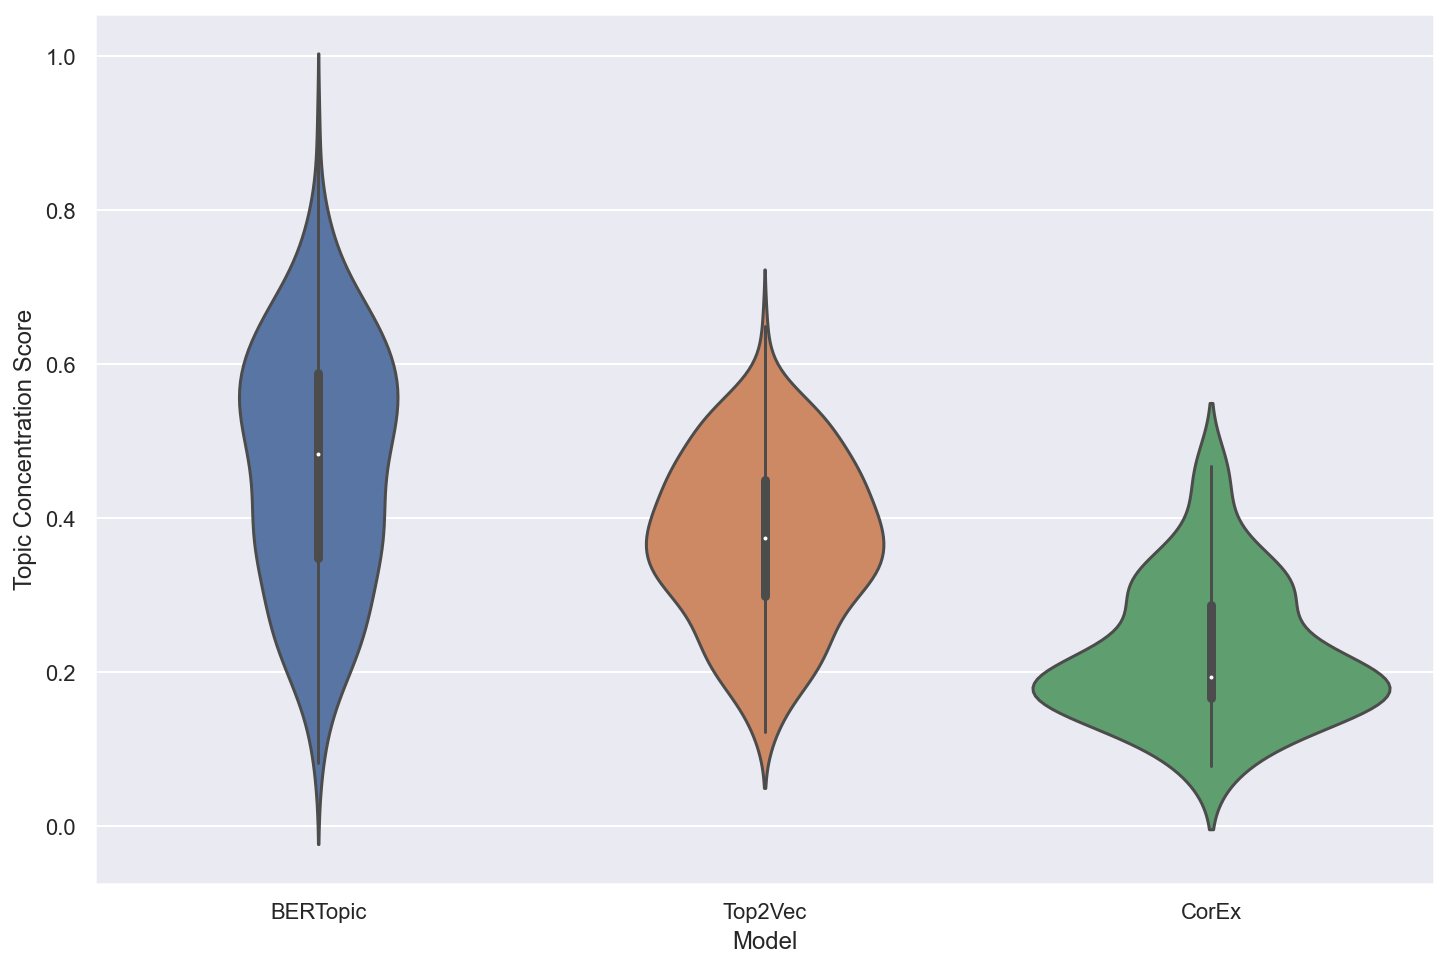

In [297]:
my_order = df_topic_conc_merged.groupby(by=['model_name'])["topic_conc"].median().iloc[::-1].index
sns.violinplot(x='model_name',y='topic_conc', data = df_topic_conc_merged,order=['BERTopic','Top2Vec','CorEx'])
sns.set(rc={'figure.figsize':(12,8)})
plt.pyplot.xlabel("Model")
plt.pyplot.ylabel("Topic Concentration Score")
plt.pyplot.savefig('topic_concentration_scores.png')